# mnist-visual-fields

Importing libraries

In [3]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from typing import Tuple, List, Dict, Generator
from attr import define
import os
import time
from multiprocessing import Pool
import pickle as pkl
from itertools import combinations
import ipywidgets as widgets
from IPython.display import display
import re
#import memory_profiler

Libary to get memory consumption

In [4]:
%load_ext memory_profiler

Check if tf is using GPU

In [5]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


Utility functions

In [78]:
def normalize_ndarray(array: np.ndarray) -> np.ndarray:
    max = np.max(array)
    min = np.min(array)

    if (max - min) == 0:
        return array
    else:
        return (array - min) / (max - min)

def show_dataset(
    x_data_left: np.array, x_data_right: np.array, y_data: np.array, num_images: int
) -> None:
    fig1, ax = plt.subplots(num_images, 2, figsize=(2.4, num_images * 1.2))
    for i in range(num_images):
        ax[i, 0].imshow(x_data_left[i], cmap="binary", vmax=1)
        ax[i, 1].imshow(x_data_right[i], cmap="binary", vmax=1)

        ax[i, 1].text(45, 18, f"{y_data[i]}", fontsize=20)

        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])

    plt.show()

def show_single_digit(data: np.array, index: int, print_index: bool=False) -> None:
    image = data[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 3))

    ax1.imshow(image, cmap="binary", vmax=1)
    ax1.set_title("Image")
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    if print_index:
        ax2.set_title("Index")
        ax2.text(0.4, 0.5, f"{index}", fontsize=20)
        ax2.set_aspect("equal")
        ax2.axis("off")
    else:
        ax2.set_visible(False)

    plt.show()

def show_double_digit(x_data_left, x_data_right, y_data, index):
    image_left = x_data_left[index]
    image_right = x_data_right[index]
    digit = y_data[index]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3, 3))

    ax1.imshow(image_left, cmap="binary", vmax=1)
    ax1.set_title("Image")
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(image_right, cmap="binary", vmax=1)
    ax2.set_title("Image")
    ax2.set_aspect("equal")
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.set_title("Digit")
    ax3.text(0.4, 0.5, f"{digit}", fontsize=20)
    ax3.set_aspect("equal")
    ax3.axis("off")

    plt.show()

def get_current_time_string() -> str:
    current_time = time.localtime()
    return f'{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_{current_time.tm_hour}-{current_time.tm_min}-{current_time.tm_sec}'

def get_n_digits_indices(y_data, digit: int, n: int) -> Generator[int, None, None]:
    """
    Get the indices of n instances of a given digit in the dataset

    Inputs:
    y_data: np.array: the labels of the digits
    digit: int: the digit to display
    n: int: the number of instances of the digit to retreive
    
    Ouput:
    returns a list containing n indices of the digit in the dataset or an empty list if the digit is not found
    """
    max_size = len(y_data)
    idx = 0
    digits_found = 0
    while idx < max_size and digits_found < n:
        if y_data[idx] == digit:
            digits_found += 1
            yield idx
        idx += 1

def display_n_digits(x_data, y_data, digit: int, n: int) -> None:
    """
    Display n instances of a digit from the dataset and their corresponding indices in the dataset

    Inputs:
    x_data: np.array: the dataset of digits
    y_data: np.array: the labels of the digits
    digit: int: the digit to display
    n: int: the number of instances of the digit to display
    
    Ouput:
    displays n instances of the digit and their corresponding indices in the dataset
    """
    digit_indices = get_n_digits_indices(y_data, digit, n)
    for idx in digit_indices:
        show_single_digit(x_data, idx, print_index=True)    

def plot_training_testing_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Testing Accuracy")
    plt.title("Training and Testing Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def is_double_visual_field_model(model):
    return type(model.input) == list # If input is a list, it is a double visual field model

def is_left_visual_field_model(model):
    return not is_double_visual_field_model(model) and 'left' in model.input.name

def show_dataset_sizes(*data):
    for d in data:
        print(d.shape)

def compute_forward_pass(model: keras.Model, *input_data: np.array) -> List[np.array]:
    '''
        Returns a list with the activations of each layer of the model for the input data.

        Input:
        model: keras.Model: model to be used for prediction
        data: np.array: input data to be used for prediction, one array for each visual field
        
        Output: [np.array, ...]
    
    '''
    layers = model.layers
    activations = {}
    n_computed_layers = 0
    # Compute forward pass for the input layers
    match len(input_data):
        case 1:
            activations[layers[0].name], = input_data
            n_computed_layers = 1

        case 2:
            left_input, right_input = input_data
            activations = {layers[0].name: left_input, layers[1].name: right_input}
            n_computed_layers = 2
        
    # Compute forward pass for the rest of the layers
    for layer in layers[n_computed_layers:]:
        layer_type = layer.__class__.__name__
        layer_name = layer.name
        inbound_layers = layer._inbound_nodes[0].inbound_layers

        if type(inbound_layers) == list: # Inbound layers is a list when the layer has multiple inputs or no inputs
            match len(inbound_layers):
                case 0:
                    raise NotImplementedError('Layer with no inbound layers not implemented')
                case 1:
                    raise Exception('Node.inbound_layers should not return a list with one element')
                case 2:
                    match layer_type:
                        case 'Concatenate':
                            X = np.concatenate((activations[inbound_layers[0].name], activations[inbound_layers[1].name]), axis=0)
                            activations[layer_name] = X
                        case _:
                            raise NotImplementedError(f'Layer type {layer_type} not implemented')            
        else:
            inbound_layer_name = inbound_layers.name
            X = activations[inbound_layer_name]
            match layer_type:
                case 'Flatten':
                    X = X.flatten()
                    activations[layer_name] = X
                case 'Dense':
                    W, B = layer.get_weights()
                    g = layer.activation
                    Z = np.zeros((W.shape[1]))
                    for j in range(len(Z)):
                        for i in range(len(X)):
                            Z[j] += W[i][j] * X[i]
                        Z[j] += B[j]
                    if g.__name__ == 'softmax':
                        F = tf.nn.softmax(Z) # There is a bug in keras 2.15 that makes softmax not work on 1D array
                    else:
                        F = g(Z)
                    activations[layer_name] = F

    activations_numpy = []
    for activation in activations.values():
        try:
            activation = activation.numpy()
        except AttributeError:
            pass
        activations_numpy.append(activation)
        
    return activations_numpy

def save_obj(path: str, obj: any) -> None:
    with open(path, 'wb') as f:
        pkl.dump(obj, f)

def load_obj(path: str) -> any:
    with open(path, 'rb') as f:
        return pkl.load(f)

def compute_cosine_similarity(vec_a: np.array, vec_b: np.array) -> float:
    """
    Computes the cosine similarity between two vectors

    Input:
    vec_a: np.array: first vector
    vec_b: np.array: second vector

    Output:
    float: cosine similarity between vec_a and vec_b
    """
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def is_left_visual_field_layer(layer: keras.layers.Layer) -> bool:
    return 'left' in layer.name

def is_left_visual_field_layer_rec(layer: keras.layers.Layer) -> bool:
    if 'input' in layer.name:
        return True if 'left' in layer.name else False
    else:
        inbound_layers = layer._inbound_nodes[0].inbound_layers
        inbound_layer = inbound_layers if type(inbound_layers) != list else inbound_layers[0]
        return is_left_visual_field_layer_rec(inbound_layer)

Generating dataset functions

In [7]:
def shuffle_visual_field_dataset(
    x_data: np.array, y_data: np.array
) -> Tuple[np.array, np.array]:
    # shuffles dataset comprised of two arrays

    n = len(y_data)
    unique_indices = np.random.permutation(
        n
    )  # generates random permutation of list in range(0, n)
    x_data = x_data[unique_indices]
    y_data = y_data[unique_indices]

    return x_data, y_data


def shuffle_two_visual_fields_dataset(
    x_data_left: np.array, x_data_right: np.array, y_data: np.array
) -> Tuple[np.array, np.array, np.array]:
    # Shuffles dataset comprised of three arrays

    n = len(y_data)
    unique_indices = np.random.permutation(
        n
    )  # generates random permutation of list in range(0, n)
    x_data_left = x_data_left[unique_indices]
    x_data_right = x_data_right[unique_indices]
    y_data = y_data[unique_indices]

    return x_data_left, x_data_right, y_data


def shuffle_and_double_dataset(
    x_data: np.array, y_data: np.array
) -> Tuple[np.array, np.array]:
    x_data1, y_data1 = shuffle_visual_field_dataset(x_data, y_data)
    x_data2, y_data2 = shuffle_visual_field_dataset(x_data, y_data)

    x_data_concatenated = np.concatenate((x_data1, x_data2))
    y_data_concatenated = np.concatenate((y_data1, y_data2))

    return x_data_concatenated, y_data_concatenated


def build_visual_field_data(
    x_data: np.array, y_data: np.array, n: float
) -> Tuple[np.array, np.array]:
    """
    Builds the dataset for a single visual field, choosing random values from the input.

    Input:
    x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit represented by x_data.
    n: float: size of the final dataset

    Output:
    x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit of the visual field.
    """

    original_size = len(y_data)
    random_indices = np.random.choice(np.arange(0, original_size), n)
    x_data_visual_field = x_data[random_indices]
    y_data_visual_field = y_data[random_indices]

    return x_data_visual_field, y_data_visual_field


def build_double_visual_fields_dataset(
    x_data: np.array,
    y_data: np.array,
    final_size: float = 4,
    proportion_cs: float = 0.5,
    proportion_left: float = 0.5,
    full_attention_value: float = 1,
    reduced_attention_value: float = 0.5,
    ss_attention_value: float = 0.5,
) -> Tuple[np.array, np.array, np.array]:
    """
    Builds an entire double visual fields dataset, comprised of two visual fields, left and right, and an array of the corresponding answer value for both visual fields.

    Input:
    x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit represented by x_data.
    final_size: float: how many times the final dataset is bigger than the input data. Default is 4.
    proportion_cs: float: proportion of entries in the final dataset that have CS over SS. Default is 0.5.
    proportion_left: float: proportion of entries in the final dataset that have attention on the left visual field. Default is 0.5.
    full_attention_value: float: value of the full attention in CS. Default is 1.
    reduced_attention_value: float: value of the reduced attention in CS. Default is 0.5.
    ss_attention_value: float: value of the attention for SS. Default is 0.5.

    Output:
    x_data_left: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
    x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
    y_data: np.array(int): corresponding value of the digit that has most attention considering both visual fields.
    """

    n = len(y_data) * final_size
    x_data_left, y_data_left = build_visual_field_data(x_data, y_data, n)
    x_data_right, y_data_right = build_visual_field_data(x_data, y_data, n)

    y_data_final = np.zeros(n, dtype=int)
    for i in range(n):
        data_with_cs = np.random.choice(
            [False, True], p=[1 - proportion_cs, proportion_cs]
        )
        data_with_left_attention = np.random.choice(
            [False, True], p=[1 - proportion_left, proportion_left]
        )

        # determines value of attention if dataset entry is CS or SS
        if data_with_cs:
            attention = full_attention_value
            no_attention = reduced_attention_value
        else:
            attention = ss_attention_value
            no_attention = 0

        # determines which visual field has attention
        if data_with_left_attention:
            x_data_left[i] *= attention
            x_data_right[i] *= no_attention
            y_data_final[i] = y_data_left[i]
        else:
            x_data_left[i] *= no_attention
            x_data_right[i] *= attention
            y_data_final[i] = y_data_right[i]

    return x_data_left, x_data_right, y_data_final

## Importing MNIST dataset and normalizing input

In [8]:
mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train = normalize_ndarray(x_train)
x_test = normalize_ndarray(x_test)

## Generating training and testing data

### Building training dataset

In [206]:
x_train_left, x_train_right, y_train_final = build_double_visual_fields_dataset(
    x_train,
    y_train,
    final_size=4,
    proportion_cs=0.5,
    proportion_left=0.5,
    full_attention_value=1,
    reduced_attention_value=0.5,
    ss_attention_value=0.5,
)

### Showing training dataset

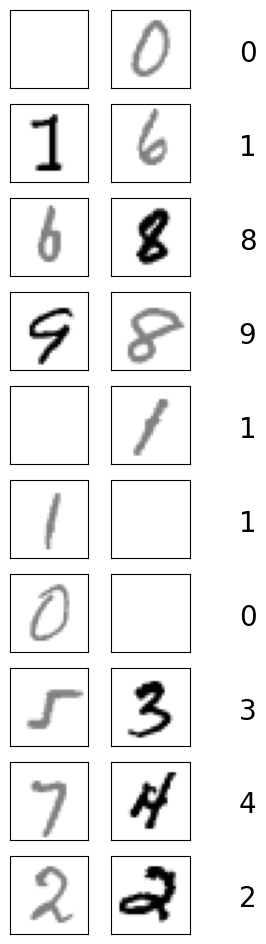

In [207]:
show_dataset(x_train_left, x_train_right, y_train_final, 10)

### Building testing dataset

In [208]:
x_test_left, x_test_right, y_test_final = build_double_visual_fields_dataset(
    x_test,
    y_test,
    final_size=1,
    proportion_cs=0.5,
    proportion_left=0.5,
    full_attention_value=1,
    reduced_attention_value=0.5,
    ss_attention_value=0.5,
)

### Showing testing dataset

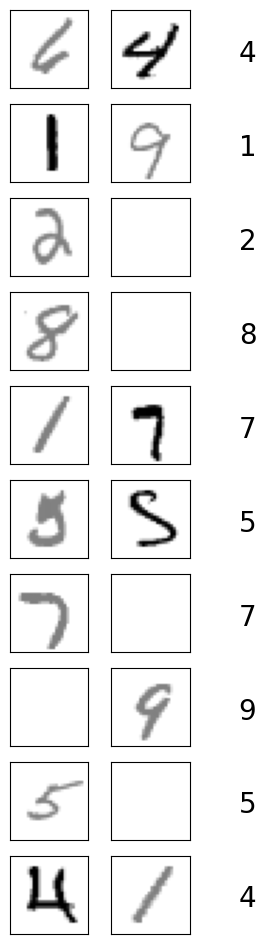

In [209]:
show_dataset(x_test_left, x_test_right, y_test_final, 10)

Plotting neural network dataclasses

In [9]:
@define
class Position:
    """
    Class representing a position with two coordinates
    """

    x: float
    y: float

    def copy(self):
        return Position(self.x, self.y)

    def __str__(self):
        return f"Position({self.x}, {self.y})"


@define
class Neuron:
    """
    Class representing a neuron in the Neural Network plot
    """

    activation: float
    position: Position
    radius: float


@define
class Layer:
    """
    Class representing a layer in the Neural Network plot
    """

    model: keras.layers
    activations: List[float] | None = None
    position: Position | None = None
    neurons: List[Neuron] | None = None
    num_neurons: int | None = None

    def __attrs_post_init__(self):
        self.neurons = ([])  # This is needed to solve bug where list is not empty at start
        self.num_neurons = self.model.output_shape[-1]

    def is_output_layer(self):
        return not bool(self.model._outbound_nodes)

    def set_y_position(self, y_position):
        self.position.y = y_position

Plotting neural network auxiliary functions

In [10]:
def get_index_of_digit(y_data, digit):
    """
    Return index of first occurance of digit in the dataset, if digit is not found, returns -1
    """
    n = len(y_data)
    index = 0
    while y_data[index] != digit and index < n - 1:
        index += 1

    return index if y_data[index] == digit else -1

def get_single_visual_field_digit(x_data, y_data, digit):
    """
    Returns the first instance of the digit in the Single Visual Field dataset
    """
    index = get_index_of_digit(y_data, digit)

    return np.array([x_data[index]])

def get_double_visual_field_digit(x_data_left, x_data_right, y_data, digit):
    """
    Returns the first instance of the digit in the Double Visual Field dataset
    """
    index = get_index_of_digit(y_data, digit)
    if index == -1:
        print("Error! Digit wasn't found!")

    return np.array([x_data_left[index]]), np.array([x_data_right[index]])

def get_activations_single_visual_field(model: keras.Model, x_data: np.array, vf_digit: Tuple[int, float] = None):
    """
    Generates the individual neuron activation values for a prediction with a single visual field Neural Network
    """

    # Getting input data
    idx, attention = vf_digit
    input_data = np.array([x_data[idx]]) * attention

    # Creating intermediate models
    intermediate_layer_models = [
        keras.models.Model(
            inputs=model.input, outputs=layer.output
        )
        for layer in model.layers
    ]

    # Getting activations
    activations = [
        intermediate_layer_model([input_data], training=False)[0]
        for intermediate_layer_model in intermediate_layer_models
    ]   # Model result is returned inside a list, hence we get the first element of that list

    return activations

def get_activations_double_visual_field(
    model: keras.Model,
    x_data: np.array,
    left_vf_digit: Tuple[int, float] = None,
    right_vf_digit: Tuple[int, float] = None
):
    """
    Generates the individual neuron activation values for a prediction with a double visual field Neural Network
    """

    # Getting input data
    left_idx, left_attention = left_vf_digit
    input_data_left = np.array([x_data[left_idx]]) * left_attention
    right_idx, right_attention = right_vf_digit
    input_data_right = np.array([x_data[right_idx]]) * right_attention

    # Creating intermediate models
    intermediate_layer_models = [
        keras.models.Model(
            inputs=model.input, outputs=layer.output
        )
        for layer in model.layers
    ]

    # Getting activations
    activations = [
        intermediate_layer_model([input_data_left, input_data_right], training=False)[0]
        for intermediate_layer_model in intermediate_layer_models
    ]   # Model result is returned inside a list, hence we get the first element of that list

    return activations

def get_image(neural_activation):
    """
    Transforms the activity of the neurons of a Neural Network into a 2D matrix that can be seen as an image with plt.imshow
    """
    num_neurons = len(neural_activation)
    num_rows = int(np.sqrt(num_neurons))
    num_cols = int(np.ceil(num_neurons / num_rows))

    return np.array(neural_activation).reshape(num_rows, num_cols)

def generate_image_annotation_box(
    image, position, size, border_size=1, border_color="black"
):
    """
    Generates the AB of the image to be positioned in the figure
    """
    img = OffsetImage(image, zoom=size)
    ab = AnnotationBbox(img, (position.x, position.y), frameon=False, pad=0)

    return ab

def generate_image_annotation_box_grayscale(
    image, position, size, border_width=1, border_color="black"
):
    """
    Generates the AnnotationBbox of the grayscale image with a border to be positioned in the figure
    """

    img = OffsetImage(
        image, zoom=size, cmap="binary", norm=plt.Normalize(vmin=0, vmax=1)
    )
    ab = AnnotationBbox(
        img,
        (position.x, position.y),
        frameon=True,
        pad=0,
        bboxprops=dict(
            edgecolor=border_color, linewidth=border_width, boxstyle="square,pad=0.1"
        ),
    )

    return ab

def get_number_of_neurons_in_layer(layer):
    """
    Returns the number of neurons present in a layer of a Neural Network
    """
    return layer.output_shape[-1]

def get_digit_from_y_spacing(total_position_plotted, y_spacing):
    """
    Returns the digit an output neuron represents based on how many neurons have been plotted
    """
    return np.ceil(total_position_plotted / y_spacing)

def calculate_image_size(number_neurons):
    """
    Computes size of image based on the number of neurons
    """
    # Determined in tests
    a = -5 / 1536
    b = 533 / 96
    return number_neurons * a + b

def compute_sizes(top):
    bottom = 1 - top
    return top, bottom, bottom, top  # top, bottom, left, right

def generate_output_models(model):
    # Generate not trainable copy of model
    model_copy = keras.models.clone_model(model)
    model_weights = model.get_weights()
    model_copy.set_weights(model_weights)
    for layer in model_copy.layers:
        layer.trainable = False 
    
    # Generate output models of each hidden layer
    output_models = []
    for layer in model_copy.layers[4:-2]:
        out_model_input = model_copy.input # [left_input, right_input]
        if 'left' in layer.name:
            out_model_input = out_model_input[0]
        elif 'right' in layer.name:
            out_model_input = out_model_input[1]
            
        out_model_output = keras.layers.Dense(10, activation="softmax")(layer.output)
        out_model = keras.models.Model(
        inputs=out_model_input, outputs=out_model_output
        )
        output_models.append(out_model)

    return output_models

def compute_digits_model_predicts(model: keras.Model, *data: np.array) -> List[Tuple[int, float]]:
    '''
        Returns a list with the activations of the output layer of the model for each digit.
        The list is sorted in descending order of activation.

        Input:
        model: keras.Model: model to be used for prediction
        *data: np.array: input data to be used for prediction, could be one or two arrays
        
        Output: [(digit, activation), ...]
    
    '''
    activations = None
    if is_double_visual_field_model(model):
        activations = compute_forward_pass(model, data[0], data[1])
    else:
        if is_left_visual_field_model(model):
            activations = compute_forward_pass(model, data[0])
        else:
            activations = compute_forward_pass(model, data[1])
    
    activations = activations[-1]
    digit_activations = []
    for digit, activation in enumerate(activations):
        digit_activations.append((digit, activation))
    
    digit_activations = sorted(digit_activations, key=lambda item: item[1], reverse=True)
        
    return digit_activations

Plotting single visual field neural network function

In [11]:
def display_single_visual_field_mnist_nn_execution(
    model, x_data, y_data, input_digit, max_neurons, weight_plot_threshold
):
    """
    Receives a trained Neural Network model and and input digit, plotting the full neural network execution
    """

    """ Determining matplotlib figure parameters """

    fig = plt.figure(
        figsize=(12, 12)
    )  # TODO: generate size based on max number of neurons on layer
    ax = fig.gca()
    ax.axis("off")
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9

    """ Calculating neural network activations """

    model_activations = get_activations_single_visual_field(
        model, input_digit, x_data, y_data
    )

    """ Determining neural network figure parameters """

    model_number_of_layers = len(model.layers)
    layer_spacing = (right - left) / (model_number_of_layers - 1)  # Space between each layer in the plot
    connection_opacity = 0.2
    color_connection_opacity = 0.5
    image_y_position = 0.5
    current_position = Position(left, image_y_position)  # Initial position

    """ Plotting layers """

    plotted_layers = []
    for i in range(model_number_of_layers):
        model_layer = model.layers[i]
        layer_activations = model_activations[i]  # TODO: Can raise error if number of activations not equal to number of layers

        layer = Layer(model=model_layer, activations=layer_activations)
        plotted_layers.append(layer)  # Adding layer to plotted layers

        # Depending on the type of layer, different  figures will be created to represent it

        # -- Flatten layer --
        if "flatten" in layer.model.name:
            # If it is the input layer
            if i == 0:
                layer.position = current_position.copy()
                ab = generate_image_annotation_box_grayscale(
                    get_image(layer.activations),
                    layer.position,
                    size=calculate_image_size(layer.num_neurons),
                )
                ax.add_artist(ab)

        #  -- Dense layer --
        elif "dense" in layer.model.name:

            # -- Plotting neurons of dense layer --
            if layer.num_neurons < max_neurons:  # Plotting individual neurons
                current_position.x += layer_spacing
                current_position.y = top
                layer.position = current_position.copy()

                previous_layer = plotted_layers[i - 1]  # Gets previous layer
                layer_weights = normalize_ndarray(layer.model.get_weights()[0])

                neuron_spacing = (top - bottom) / layer.num_neurons  # Space between each neuron in the plot
                layer_activations = (
                    normalize_ndarray(layer_activations)
                    if not layer.is_output_layer()
                    else layer_activations
                )  # Normalize layer activations if it is not output layer
                for idx, neuron_activation in enumerate(layer_activations):
                    # -- Plotting each neuron --
                    neuron = Neuron(
                        neuron_activation,
                        current_position.copy(),
                        radius=neuron_spacing / 4,
                    )
                    layer.neurons.append(neuron)  # Adding neuron to plotted layer
                    neuron_circle = plt.Circle(
                        xy=(current_position.x, current_position.y),
                        radius=neuron.radius,
                        color=plt.cm.viridis(neuron_activation),
                        ec="k",
                    )
                    ax.add_artist(neuron_circle)  # Plots neuron

                    # -- Plotting connections of neurons to previous layer --
                    if (previous_layer.num_neurons < max_neurons):  # Checks if the number of neurons on the previous layer doesn't exceed the maximum to be plotted)
                        layer_weights_neuron = layer_weights[:, idx]
                        for previous_neuron, connection_weight in zip(previous_layer.neurons, layer_weights_neuron):
                            # Checks if weight is above threshold
                            if connection_weight >= weight_plot_threshold:
                                connection = plt.Line2D(
                                    [
                                        current_position.x - neuron.radius,
                                        previous_neuron.position.x + previous_neuron.radius,
                                    ],
                                    [current_position.y, previous_neuron.position.y],
                                    color=plt.cm.viridis(connection_weight),
                                    alpha=color_connection_opacity,
                                )
                                ax.add_artist(connection)  # Plots connection to previous neurons

                    else:  # In case it does, only a single conncetion from each neuron will be shown connecting to the previous layer
                        previous_layer_position = Position(previous_layer.position.x, previous_layer.position.y)  # Saves position of previous layer
                        image_offset = 0.065
                        connection = plt.Line2D(
                            [
                                current_position.x - neuron.radius,
                                previous_layer_position.x + image_offset
                            ],
                            [current_position.y, previous_layer_position.y],
                            color="k",
                            alpha=connection_opacity,
                        )
                        ax.add_artist(connection)  # Plots connection to image

                    # -- Plotting digit and activation if it is the output layer --
                    if i == model_number_of_layers - 1:
                        neuron_digit = get_digit_from_y_spacing(
                            (top - current_position.y), neuron_spacing
                        )
                        text_offset_x = 0.001
                        text_offset_y = 0.005
                        text = plt.Text(
                            current_position.x + neuron.radius + text_offset_x,
                            current_position.y - text_offset_y,
                            f"{neuron_digit}: {neuron_activation:.4f}",
                            fontsize=8,
                            color="k",
                        )
                        ax.add_artist(text)  # Adds corresponding digit and activation of neuron

                    # Changes the current y position to plot the next neuron
                    current_position.y -= neuron_spacing

            else:  # If the number of neurons in the layer exceeds the maximum TODO: Color connections if previous layer has few neurons
                current_position.x += layer_spacing
                current_position.y = image_y_position
                layer.position = current_position.copy()

                # -- Plotting layer as image --
                ab = generate_image_annotation_box(
                    get_image(layer.activations),
                    layer.position,
                    size=calculate_image_size(layer.num_neurons),
                )
                ax.add_artist(ab)

                # -- Plotting connections of image to previous layer --
                previous_layer = plotted_layers[i - 1]  # Gets previous layer
                if (previous_layer.num_neurons < max_neurons):  # Checks if the number of neurons on the previous layer doesn't exceed the maximum to be plotted
                    for previous_neuron in previous_layer.neurons:
                        connection = plt.Line2D(
                            [
                                current_position.x,
                                previous_neuron.position.x + previous_neuron.radius,
                            ],
                            [current_position.y, previous_neuron.position.y],
                            color="k",
                            alpha=connection_opacity,
                        )
                        ax.add_artist(connection)  # Plots connection to previous neurons
                else:  # If previous layer exceeds the maximum number of neurons plotted
                    connection = plt.Line2D(
                        [current_position.x, previous_layer.position.x],
                        [current_position.y, previous_layer.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to previous neurons

    fig.savefig("nn.png")

Plotting double visual field neural network function

In [105]:
def display_double_visual_field_mnist_nn_execution(
    model,
    data,
    left_vf_digit: Tuple[int, float],
    right_vf_digit: Tuple[int, float],
    max_neurons=300,
    weight_plot_threshold=0.5,
    output_models=None,
    k=3,
    save_image=True
):
    """
    Receives a trained Neural Network model with two visual fields and and input digit, plotting 
    the full neural network execution.
    Obseravtion: this code currently doesn't support Convolution or MaxPool layers and layers with 
    too many neurons.

    Input:
    model: keras.Model: model to be used for visualization
    in a layer exceeds this value, the layer will be plotted as an image
    data: np.array: input dataset to be used for visualization
    left_vf_digit: Tuple[int, float]: index of the digit in the dataset to be used as the left visual field and the attention value
    right_vf_digit: Tuple[int, float]: index of the digit in the dataset to be used as the right visual field and the attention value
    max_neurons: int: maximum number of neurons to be plotted in a layer, if the number of neurons (default: 300)
    weight_plot_threshold: float: minimum weight value to be plotted, considering normalized values between 0 and 1 (default: 0.5)
    output_models: List[keras.Model] | None: list of models to be used as attribute lenses for each layer (default: None)
    k: int: number of top digit activations displayed for each attribute lens (default: 3)
    save_image: bool: if the neural network plot should be saved as image (default: True)

    Output:
    saves the image in images/ or None
    """

    """ Determining matplotlib figure parameters """

    fig = plt.figure(
        figsize=(24, 24)
    )  # TODO: generate size based on max number of neurons on layer
    ax = fig.gca()
    ax.axis("off")
    top, bottom, left, right = compute_sizes(top=0.98)
    precision = 4  # Number of digits of precision when calculating positions
    middle = round((top + bottom) / 2, ndigits=precision)
    middle_spacing = 0.02

    """ Getting input data """

    left_idx, left_attention = left_vf_digit
    input_data_left = np.array([data[left_idx]]) * left_attention

    right_idx, right_attention = right_vf_digit
    input_data_right = np.array([data[right_idx]]) * right_attention

    """ Calculating neural network activations """

    # Using custom forward pass function
    model_activations = compute_forward_pass(model, input_data_left, input_data_right)
    
    # model_activations = get_activations_double_visual_field(
    #         model, data, left_vf_digit, right_vf_digit
    #     )
        
    """ Determining neural network figure parameters """

    model_number_of_layers = len(model.layers)
    layer_spacing = (right - left) / (model_number_of_layers - 1)  # Space between each layer in the plot TODO: tweak so it looks better on denser models
    connection_opacity = 0.2
    color_connection_opacity = 0.5
    left_vf_position = Position(left, 1.5 * middle)  # Initial position of left visual field
    right_vf_position = Position(left, 0.5 * middle)  # Initial position of right visual field

    """ Plotting layers """

    plotted_layers_left_vf = []
    plotted_layers_right_vf = []
    plotted_layers_concatenated = []
    layers_reference = None

    # Input layers

    # Left
    input_layer_left = Layer(model=model.layers[2], activations=model_activations[2])
    input_layer_left.position = left_vf_position.copy()
    ab = generate_image_annotation_box_grayscale(
        get_image(input_layer_left.activations),
        input_layer_left.position,
        size=calculate_image_size(input_layer_left.num_neurons),
    )
    ax.add_artist(ab)
    plotted_layers_left_vf.append(input_layer_left)

    # Right
    input_layer_right = Layer(model=model.layers[3], activations=model_activations[3])
    input_layer_right.position = right_vf_position.copy()
    ab = generate_image_annotation_box_grayscale(
        get_image(input_layer_right.activations),
        input_layer_right.position,
        size=calculate_image_size(input_layer_right.num_neurons),
    )
    ax.add_artist(ab)
    plotted_layers_right_vf.append(input_layer_right)

    # Plotting the rest of the layers

    # Variables used to keep track of each visual field
    left_idx = 0
    right_idx = 0
    concat_idx = 0
    concat_left_idx = 0
    concat_right_idx = 0
    neuron_digit = 0
    is_concatenated = False
    is_concatenate_layer = False
    is_output_layer = False
    plot_connections_left_vf = True  # Used in concatenate layer

    # Plotting layers, either left vf, right vf or concatenated vf
    for i in range(4, model_number_of_layers):
        model_layer = model.layers[i]
        layer_activations = model_activations[i]
        layer = Layer(model=model_layer, activations=layer_activations)

        # Determining if it is plotting left vf, right vf or concatenated vf
        vf_top = top
        vf_bottom = bottom
        if "left" in layer.model.name:
            layers_reference = plotted_layers_left_vf
            left_idx += 1
            layers_idx = left_idx
            vf_bottom = middle + middle_spacing
        elif "right" in layer.model.name:
            layers_reference = plotted_layers_right_vf
            right_idx += 1
            layers_idx = right_idx
            vf_top = middle - middle_spacing
        elif "concatenate" in layer.model.name:
            is_concatenate_layer = True
            is_concatenated = True
            layers_reference = plotted_layers_concatenated
            layers_idx = concat_idx
        elif is_concatenated:
            concat_idx += 1
            layers_idx = concat_idx
        if i == model_number_of_layers - 1:
            is_output_layer = True
            output_offset = 0.2
            vf_top = middle + output_offset
            vf_bottom = middle - output_offset

        # Adds current layer to plotted layers for each visual field
        layers_reference.append(layer)

        # Gets previous layer and layer weights
        if not is_concatenate_layer:
            layer_weights = normalize_ndarray(layer.model.get_weights()[0])  # Retruns 2d-array (num_neurons_previous_layer x num_neurons_current_layer)
                                                                             # get_weights returns (weights, bias)
            previous_layer = layers_reference[layers_idx - 1]
            current_position = previous_layer.position.copy()

        # Determines and saves position of current layer
        current_position.x += layer_spacing
        current_position.y = vf_top
        layer.position = current_position.copy()

        # Determines neuron spacing
        neuron_spacing = (vf_top - vf_bottom) / layer.num_neurons
        # ns_min = 0.05
        # neuron_spacing = min(neuron_spacing, ns_min)

        # Normalize layer activations if it is not output layer
        layer_activations = (
            normalize_ndarray(layer_activations)
            if not is_output_layer
            else layer_activations
        )
        for idx, neuron_activation in enumerate(layer_activations):
            # -- Plotting each neuron --
            neuron = Neuron(
                neuron_activation, current_position.copy(), radius=neuron_spacing / 4
            )
            layer.neurons.append(neuron)  # Adding neuron to plotted layer
            neuron_circle = plt.Circle(
                xy=(current_position.x, current_position.y),
                radius=neuron.radius,
                color=plt.cm.viridis(neuron_activation),
                ec="k",
            )
            ax.add_artist(neuron_circle)  # Plots neuron

            if not is_concatenate_layer:
                # -- Plotting connections of neurons to previous layer --
                if (previous_layer.num_neurons < max_neurons):  # Checks number of neurons on previous layer to decide if every connection will be plotted
                    layer_weights_neuron = layer_weights[:, idx]
                    for previous_neuron, connection_weight in zip(previous_layer.neurons, layer_weights_neuron):
                        # Checks if weight is above threshold
                        if connection_weight >= weight_plot_threshold:
                            connection = plt.Line2D(
                                [
                                    current_position.x - neuron.radius,
                                    previous_neuron.position.x + previous_neuron.radius,
                                ],
                                [current_position.y, previous_neuron.position.y],
                                color=plt.cm.viridis(connection_weight),
                                alpha=color_connection_opacity,
                            )
                            ax.add_artist(connection)  # Plots connection to previous neurons

                else:  # In case it does, only a single connection from each neuron will be shown connecting to the previous layer
                    image_offset = 0.032
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_layer.position.x + image_offset,
                        ],
                        [current_position.y, previous_layer.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
            # If it is the concatenate layer, show connection to corresponding neuron
            else:
                # Left
                left_vf_layer = plotted_layers_left_vf[left_idx]
                if concat_left_idx < left_vf_layer.num_neurons:
                    previous_neuron = left_vf_layer.neurons[concat_left_idx]
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_neuron.position.x + previous_neuron.radius,
                        ],
                        [current_position.y, previous_neuron.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
                    concat_left_idx += 1

                # Right
                right_vf_layer = plotted_layers_right_vf[right_idx]
                if (concat_right_idx < right_vf_layer.num_neurons and not plot_connections_left_vf):
                    previous_neuron = right_vf_layer.neurons[concat_right_idx]
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_neuron.position.x + previous_neuron.radius,
                        ],
                        [current_position.y, previous_neuron.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
                    concat_right_idx += 1

                plot_connections_left_vf = False if concat_left_idx == left_vf_layer.num_neurons else True
                
            # -- Plotting digit and activation if it is the output layer --
            if is_output_layer:
                text_offset_x = 0.002
                text_offset_y = 0.003
                text = plt.Text(
                    current_position.x + neuron.radius + text_offset_x,
                    current_position.y - text_offset_y,
                    f"{neuron_digit}: {neuron_activation:.4f}",
                    fontsize=12,
                    fontweight='bold',
                    color="k",
                )
                ax.add_artist(text)  # Adds corresponding digit and activation of neuron to scene
                neuron_digit += 1

            # Changes the current y position to plot the next neuron
            current_position.y -= neuron_spacing

        if is_concatenate_layer:
            is_concatenate_layer = False  # It will not be the concatenate layer anymore
        
        # -- Plotting k digits and activations of hidden layers --
        if output_models is not None:
            for out_model in output_models:
                if layer.model.name == [layer.name for layer in out_model.layers][-2]: # If there is a corresponding output model
                    digits_activations = compute_digits_model_predicts( # Uses custom forward pass function
                        out_model, input_data_left, input_data_right
                        )
                    
                    text_string = ''
                    for i in range(k):
                        eol = '\n' if i != k - 1 else ''
                        text_string += f'{digits_activations[i][0]}: {digits_activations[i][1]:.4f}{eol}'
                    
                    text_offset_x = -0.03
                    text_offset_y = 0.02
                    text = plt.Text(
                        current_position.x + neuron.radius + text_offset_x,
                        current_position.y - text_offset_y,
                        text_string,
                        fontsize=12,
                        fontweight='bold',
                        color="k",
                    )
                    ax.add_artist(text)

    if save_image:
        if not os.path.exists("images"):
            os.makedirs("images")
        fig.savefig(f"images/nn_dvf_{get_current_time_string()}.png")

### Creating new model

In [106]:
def model_t1_srf() -> keras.Model:
    input_layer = keras.layers.Input(shape=[28,28], name="input")
    flatten_input = keras.layers.Flatten()(input_layer)

    dense = keras.layers.Dense(32, activation="relu", name="srf_dense1")(flatten_input)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense2")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense3")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense4")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense5")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense6")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense7")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense8")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense9")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense10")(dense)
    
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense11")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense12")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense13")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense14")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense15")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense16")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense17")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense18")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense19")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="srf_dense20")(dense)

    output = keras.layers.Dense(10, activation="softmax", name="output")(dense)
    model = keras.Model(inputs=[input_layer], outputs=[output])

    return model

### Previous model definitions

In [58]:
def model_t1() -> keras.Model:
    input_left = keras.layers.Input(shape=[28,28], name="input_left")
    flatten_input_left  = keras.layers.Flatten()(input_left)

    input_right = keras.layers.Input(shape=[28,28], name="input_right")
    flatten_input_right  = keras.layers.Flatten()(input_right)

    hidden_layer_left1 = keras.layers.Dense(30, activation="relu", name="dense_left1")(flatten_input_left)
    hidden_layer_left2 = keras.layers.Dense(20, activation="relu", name="dense_left2")(hidden_layer_left1)

    hidden_layer_right1 = keras.layers.Dense(30, activation="relu", name="dense_right1")(flatten_input_right)
    hidden_layer_right2 = keras.layers.Dense(20, activation="relu", name="dense_right2")(hidden_layer_right1)

    concatenate_layer = keras.layers.concatenate([hidden_layer_left2, hidden_layer_right2], name="concatenate")

    hidden_layer_concat1 = keras.layers.Dense(40, activation="relu", name="dense_concat1")(concatenate_layer)
    hidden_layer_concat2 = keras.layers.Dense(30, activation="relu", name="dense_concat2")(hidden_layer_concat1)

    output_layer = keras.layers.Dense(10, activation="softmax")(hidden_layer_concat2)

    model_t1 = keras.Model(inputs=[input_left, input_right], outputs=[output_layer])

    return model_t1

def model_t1_extended() -> keras.Model:
    # Input layers
    left_input = keras.Input(shape=(28, 28), name="left_input")
    right_input = keras.Input(shape=(28, 28), name="right_input")
    # Flatten layers
    left_flatten = keras.layers.Flatten(name="left_flatten")(left_input)
    right_flatten = keras.layers.Flatten(name="right_flatten")(right_input)

    # Dense layers for each vf
    left_dense = keras.layers.Dense(512, activation="relu", name="left_dense1")(left_flatten)
    left_dense = keras.layers.Dense(256, activation="relu", name="left_dense2")(left_dense)
    left_dense = keras.layers.Dense(128, activation="relu", name="left_dense3")(left_dense)
    
    right_dense = keras.layers.Dense(512, activation="relu", name="right_dense1")(right_flatten)
    right_dense = keras.layers.Dense(256, activation="relu", name="right_dense2")(right_dense)
    right_dense = keras.layers.Dense(128, activation="relu", name="right_dense3")(right_dense)

    # Concatenate layer
    concatenate = keras.layers.Concatenate(name="concatenate")([left_dense, right_dense])

    # Dense layers after fusion of vfs
    dense = keras.layers.Dense(128, activation="relu", name="dense1")(concatenate)
    dense = keras.layers.Dense(64, activation="relu", name="dense2")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense3")(dense)

    # Output layer
    output = keras.layers.Dense(10, activation="softmax", name="output")(dense)

    # Model
    model = keras.Model(inputs=[left_input, right_input], outputs=output)

    return model

def model_t1_denser() -> keras.Model:
    # Input layers
    left_input = keras.Input(shape=(28, 28), name="left_input")
    right_input = keras.Input(shape=(28, 28), name="right_input")
    # Flatten layers
    left_flatten = keras.layers.Flatten(name="left_flatten")(left_input)
    right_flatten = keras.layers.Flatten(name="right_flatten")(right_input)

    # Dense layers for each vf
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense1")(left_flatten)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense2")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense3")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense4")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense5")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense6")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense7")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense8")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense9")(left_dense)
    left_dense = keras.layers.Dense(32, activation="relu", name="left_dense10")(left_dense)

    
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense1")(right_flatten)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense2")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense3")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense4")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense5")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense6")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense7")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense8")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense9")(right_dense)
    right_dense = keras.layers.Dense(32, activation="relu", name="right_dense10")(right_dense)

    # Concatenate layer
    concatenate = keras.layers.Concatenate(name="concatenate")([left_dense, right_dense])

    # Dense layers after fusion of vfs
    dense = keras.layers.Dense(32, activation="relu", name="dense1")(concatenate)
    dense = keras.layers.Dense(32, activation="relu", name="dense2")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense3")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense4")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense5")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense6")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense7")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense8")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense9")(dense)
    dense = keras.layers.Dense(32, activation="relu", name="dense10")(dense)

    # Output layer
    output = keras.layers.Dense(10, activation="softmax", name="output")(dense)

    # Model
    model = keras.Model(inputs=[left_input, right_input], outputs=output)

    return model

### Training model

Generators

In [107]:
def data_generator_double_visual_field(x_data_left, x_data_right, y_data, batch_size):
    while True:
        for i in range(0, len(y_data), batch_size):
            yield [x_data_left[i:i+batch_size], x_data_right[i:i+batch_size]], y_data[i:i+batch_size]

def data_generator_single_visual_field(x_data, y_data, batch_size):
    while True:
        for i in range(0, len(y_data), batch_size):
            yield x_data[i:i+batch_size], y_data[i:i+batch_size]

In [109]:
epochs = 50
batch_size = 256
model = model_t1_srf()

In [123]:
training_generator = data_generator_double_visual_field(
    x_train_left, x_train_right, y_train_final, batch_size
)
testing_generator = data_generator_double_visual_field(
    x_test_left, x_test_right, y_test_final, batch_size
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history_model = model.fit(
    training_generator,
    steps_per_epoch=len(y_train_final) // batch_size,
    epochs=epochs,
    validation_data=testing_generator,
    validation_steps=len(y_test_final) // batch_size,
)

Epoch 1/50
937/937 [==============================] - 10s 6ms/step - loss: 0.0374 - accuracy: 0.9909 - val_loss: 0.2141 - val_accuracy: 0.9631
Epoch 2/50
937/937 [==============================] - 5s 5ms/step - loss: 0.0375 - accuracy: 0.9909 - val_loss: 0.2464 - val_accuracy: 0.9635
Epoch 3/50
937/937 [==============================] - 5s 5ms/step - loss: 0.0368 - accuracy: 0.9910 - val_loss: 0.2077 - val_accuracy: 0.9626
Epoch 4/50
937/937 [==============================] - 5s 5ms/step - loss: 0.0365 - accuracy: 0.9911 - val_loss: 0.2276 - val_accuracy: 0.9645
Epoch 5/50
937/937 [==============================] - 5s 5ms/step - loss: 0.0346 - accuracy: 0.9914 - val_loss: 0.2266 - val_accuracy: 0.9645
Epoch 6/50
937/937 [==============================] - 5s 5ms/step - loss: 0.0328 - accuracy: 0.9920 - val_loss: 0.2341 - val_accuracy: 0.9632
Epoch 7/50
937/937 [==============================] - 4s 5ms/step - loss: 0.0349 - accuracy: 0.9916 - val_loss: 0.2303 - val_accuracy: 0.9627
Epoch

Training n models

In [110]:
models = []
n = 10
for i in range(n):
    training_generator = data_generator_single_visual_field(x_train, y_train, batch_size)
    testing_generator = data_generator_single_visual_field(x_test, y_test, batch_size)

    model = model_t1_srf()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    history_model = model.fit(
        training_generator,
        steps_per_epoch=len(y_train) // batch_size,
        epochs=epochs,
        validation_data=testing_generator,
        validation_steps=len(y_test) // batch_size,
    )
    models.append(model)

# for i in range(10):
#     model = model_t1_denser()
#     model.compile(
#         loss="sparse_categorical_crossentropy",
#         optimizer=keras.optimizers.Adam(),
#         metrics=["accuracy"],
#     )
#     history_model = model.fit(x=[x_train_left, x_train_right], y=y_train_final, epochs=epochs, batch_size=batch_size, validation_data=([x_test_left, x_test_right], y_test_final))
#     models.append(model)

Epoch 1/50
234/234 [==============================] - 10s 19ms/step - loss: 1.4512 - accuracy: 0.4587 - val_loss: 0.8195 - val_accuracy: 0.7414
Epoch 2/50
234/234 [==============================] - 3s 11ms/step - loss: 0.6397 - accuracy: 0.7918 - val_loss: 0.6638 - val_accuracy: 0.7768
Epoch 3/50
234/234 [==============================] - 2s 10ms/step - loss: 0.4558 - accuracy: 0.8653 - val_loss: 0.3911 - val_accuracy: 0.8943
Epoch 4/50
234/234 [==============================] - 3s 11ms/step - loss: 0.3498 - accuracy: 0.9049 - val_loss: 0.3459 - val_accuracy: 0.9092
Epoch 5/50
234/234 [==============================] - 3s 11ms/step - loss: 0.2915 - accuracy: 0.9230 - val_loss: 0.2722 - val_accuracy: 0.9284
Epoch 6/50
234/234 [==============================] - 3s 14ms/step - loss: 0.2540 - accuracy: 0.9340 - val_loss: 0.2689 - val_accuracy: 0.9282
Epoch 7/50
234/234 [==============================] - 3s 13ms/step - loss: 0.2340 - accuracy: 0.9397 - val_loss: 0.2740 - val_accuracy: 0.929

In [111]:
save_obj('models/models_t1_srf2', models)

In [10]:
models = load_obj('models/models_t1_denser')

### Training attribute lenses

In [ ]:
output_models = generate_output_models(model=model)
training_generator = None
for out_model in output_models:
    if is_double_visual_field_model(out_model):
        training_generator = data_generator_double_visual_field(
            x_train_left, x_train_right, y_train_final, batch_size
        )
        testing_generator = data_generator_double_visual_field(
            x_test_left, x_test_right, y_test_final, batch_size
        )
    else:
        training_generator = data_generator_single_visual_field(
            x_train, y_train, batch_size
        )
        testing_generator = data_generator_single_visual_field(
            x_test, y_test, batch_size
        )

    out_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    out_model.fit(
        training_generator,
        steps_per_epoch=len(y_train_final) // batch_size,
        epochs=epochs,
        validation_data=testing_generator,
        validation_steps=len(y_test_final) // batch_size
    )

### Save trained models

In [101]:
model_name = 'model_t1_denser'

In [102]:
model_path = f'models/{model_name}_{epochs}_{batch_size}'
os.makedirs(model_path, exist_ok=True)
model.save(model_path + '/model.keras')

### Saving attribute lenses

In [ ]:
out_models_path = model_path + '/out_models'
os.makedirs(out_models_path, exist_ok=True)
for i, out_model in enumerate(output_models):
    out_model.save(f'{out_models_path}/out_model_{i}.keras')

## Loading models

In [10]:
model_dir = 'models/model_t1_50_256/'
model_path = model_dir + 'model.keras'
out_models_dir = model_dir + 'out_models/'

model_t1_loaded = keras.models.load_model(model_path)
output_models = [keras.models.load_model(out_models_dir + out_model_filename) for out_model_filename in os.listdir(out_models_dir)]

## Visualizing neural network

### Chosing input for visualization

Left visual field

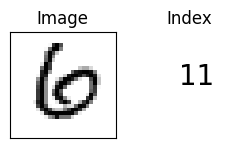

In [11]:
display_n_digits(x_test, y_test, digit=6, n=1)

Right visual field

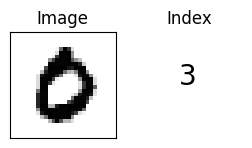

In [12]:
display_n_digits(x_test, y_test, digit=0, n=1)

### Plotting neural network

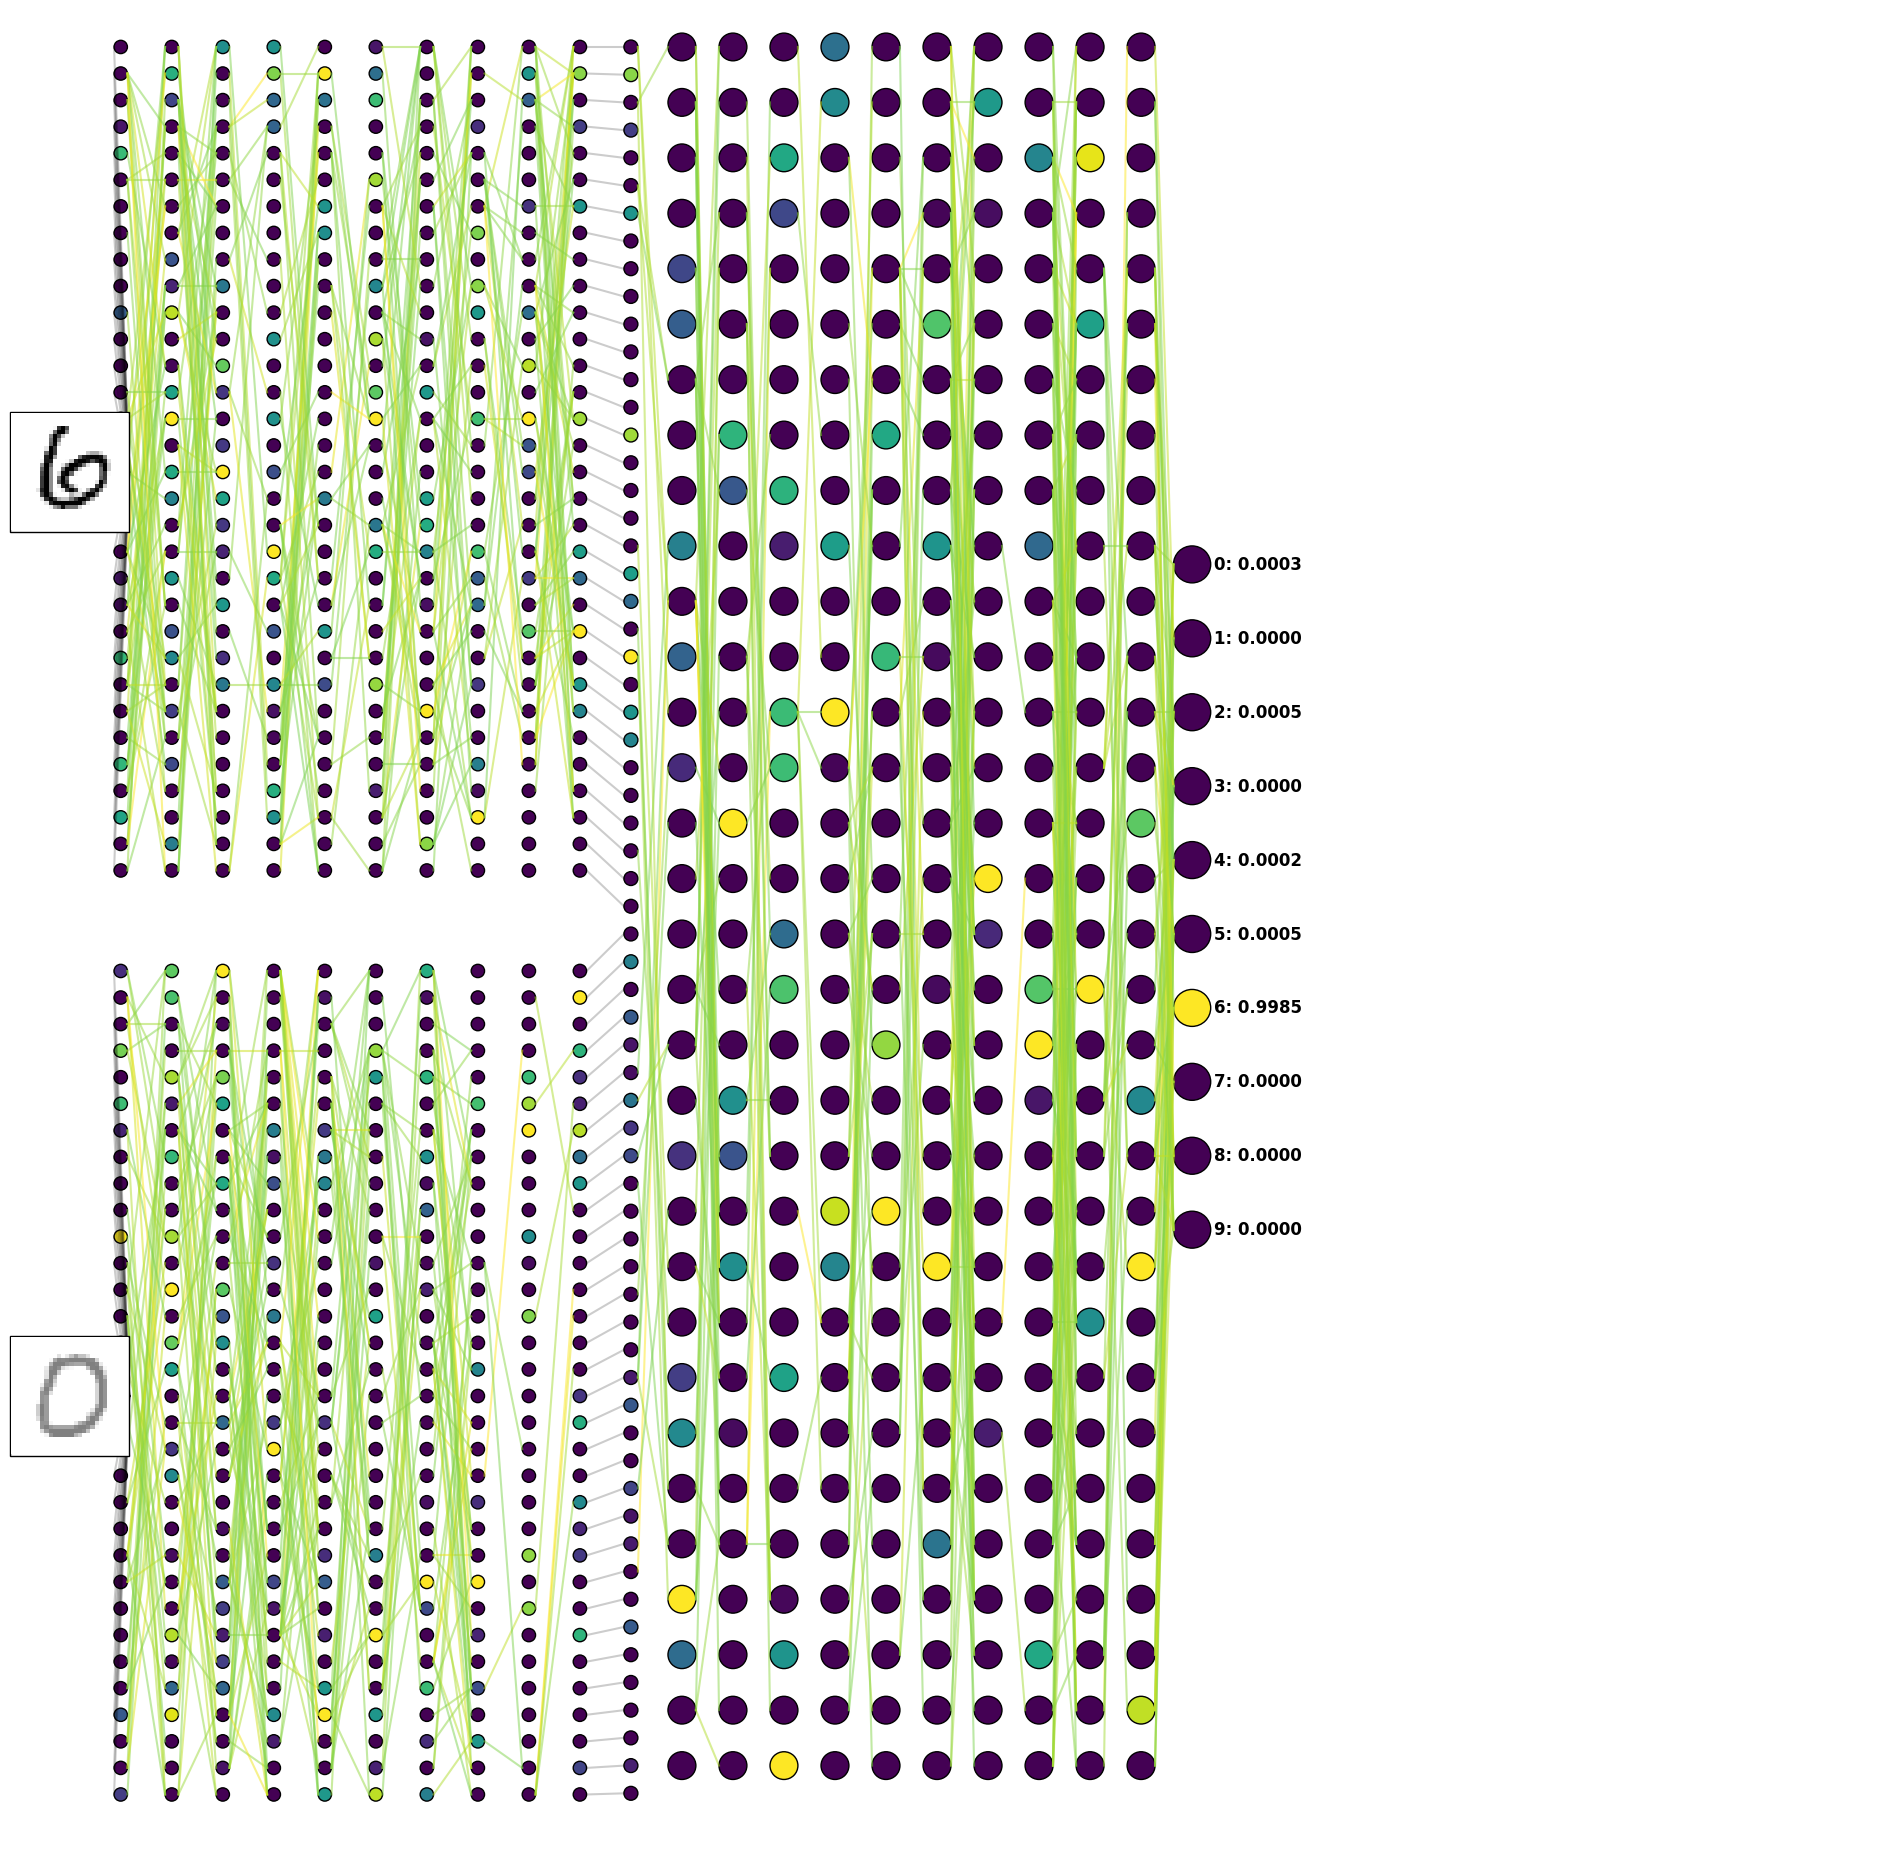

In [124]:
display_double_visual_field_mnist_nn_execution(
    model=model,
    max_neurons=600,
    weight_plot_threshold=0.8,
    data=x_test,
    left_vf_digit=(11, 1),
    right_vf_digit=(10, 0.5),
    k=3,
    save_image=True
)

### Generating cosine similarity matrix (CSM)

Generating CSM auxiliary functions

In [113]:
def fp_keras(model: keras.Model, *data: np.array) -> List[np.array]:
    """
    Calculates the forward pass of a model with two visual fields using the keras API
    """

    # Reshaping input data
    data = [d.reshape(1, 28, 28) for d in data]

    # Creating intermediate models
    intermediate_layer_models = [keras.models.Model(inputs=model.input, outputs=layer.output) for layer in model.layers]

    # Getting activations
    activations = [intermediate_layer_model(data, training=False)[0].numpy() for intermediate_layer_model in intermediate_layer_models]
    # Model result is returned inside a list, hence we get the first element of that list

    return activations

def args_generator(is_drf_model: bool, x_data: np.array, digit_instances: List[int | None], n: int) -> Generator[Tuple[np.array, np.array, Tuple[int, int, int]], None, None]:
    """
    Generates the arguments to be used in the compute_activations function

    Input:
    x_data: np.array: input dataset to be used for prototype generation
    digit_instances: List[int | None]: list of indices of the instances of each digit
    n: int: number of instances of a digit to be used to compute the prototype for that digit

    Output:
    Tuple[np.array, Tuple[int, int, bool]]: tuple containing the input data, the digit pair and the input type
    """

    for d, d_instances in enumerate(digit_instances):
        for i in range(n):
            idx = next(d_instances)
            if is_drf_model:
                yield (x_data[idx], (d, i, 0)) # Data for left visual field (input type 0)
                yield (x_data[idx], (d, i, 1)) # Data for right visual field (input type 1)
            else:
                yield (x_data[idx], (d, i, 2)) # Data for single visual field (input type 2)

def compute_mean_dynamically(mean_list: List[np.array], new_list: List[np.array], k: int) -> List[np.array]:
    """
    Computes the mean of a list of arrays dynamically using the formula:
    mean = (k * mean + new) / (k + 1)

    Input:
    mean_list: List[np.array]: list of arrays representing the mean to be calculated
    new_list: List[np.array]: list of arrays representing the new values to be added to the mean
    k: int: number of times the mean has been computed

    Output:
    List[np.array]: list of arrays representing the new mean
    """

    new_mean_list = []
    for mean, new in zip(mean_list, new_list):
        mean = (mean * k + new) / (k + 1)
        new_mean_list.append(mean)

    return new_mean_list

def generate_prototypes(model: keras.Model, x_data: np.array, y_data: np.array, n: int) -> List[List[np.array]]:
    """
    Returns a list containing the prototypes for each digit in each layer of the model

    Input:
    model: keras.Model: model to be used for prototype generation
    data: np.array: input dataset to be used for prototype generation
    n: int: number of instances of a digit to be used to compute the prototype for that digit

    Output: 
    List[List[np.array]]: list containing the prototypes for each digit in each layer of the model
    """
    
    print("[Cosine similarity] Starting prototype calculation...")
    
    prototypes = {}
    digit_instances_generator = (get_n_digits_indices(y_data, d, n) for d in range(10))
    is_drf_model = is_double_visual_field_model(model)
    args = args_generator(is_drf_model, x_data, digit_instances_generator, n)
    for (data, (d, i, input_type)) in args:
        match input_type:
            case 0:
                activations = fp_keras(g_model, data, np.zeros_like(data))
                #activations = compute_forward_pass(model, data, np.zeros_like(data))
                key = f"{d}_l"
            case 1:
                activations = fp_keras(g_model, np.zeros_like(data), data)
                #activations = compute_forward_pass(model, np.zeros_like(data), data)
                key = f"{d}_r"
            case 2:
                activations = fp_keras(g_model, data)
                #activations = compute_forward_pass(model, data)
                key = f"{d}"
        prototypes[key] = activations if i == 0 else compute_mean_dynamically(prototypes[key], activations, i)

    # Sort prototypes by visual field. This is done to make cosine similarity matrix calculations easier later on
    if is_drf_model: prototypes = {k: prototypes[k] for k in sorted(prototypes, key=lambda p: p.split('_')[1])}
    print("[Cosine similarity] Done prototype calculation!")

    return prototypes

def compute_activations(args: Tuple[np.array, np.array, Tuple[int, int, int]]) -> Tuple[List[np.array], Tuple[int, int, int]]:
    """
    Computes activations for each arg in multiprocess pool

    Input:
    args: Tuple[np.array, Tuple[int, int, bool]]: tuple containing the input data, the digit pair and the input type

    Output:
    Tuple[List[np.array], Tuple[int, int, int]]: tuple containing list of arrays containing the activations for each layer of the 
    model, the digit pair for the activations and the input type
    """

    data, (digit, i, input_type) = args
    global g_model
    match input_type:
        case 0:
            activations = compute_forward_pass(g_model, data, np.zeros_like(data))
        case 1:
            activations = compute_forward_pass(g_model, np.zeros_like(data), data)
        case 2:
            activations = compute_forward_pass(g_model, data)

    return activations, (digit, i, input_type)

def generate_prototypes_mp(model: keras.Model, x_data: np.array, y_data: np.array, n: int) -> Dict[str, List[np.array]]:
    """
    Returns a list containing the prototypes for each digit in each layer of the model. Uses multiprocessing to speed up
    the calculations

    Input:
    model: keras.Model: model to be used for prototype generation
    data: np.array: input dataset to be used for prototype generation
    n: int: number of instances of a digit to be used to compute the prototype for that digit

    Output: 
    List[List[np.array]]: list containing the prototypes for each digit in each layer of the model
    """
    
    print("[Cosine similarity] Starting multiprocess prototype calculation...")

    prototypes = {}
    digit_instances_generator = (get_n_digits_indices(y_data, d, n) for d in range(10))
    is_drf_model = is_double_visual_field_model(model)
    args_len = 20*n if is_drf_model else 10*n

    # Model needs to be global in order for multiprocessing to work (loading model from file is causing deadlock)
    global g_model
    g_model = model
    # Using generator for the args instead of list to save memory
    args = args_generator(is_drf_model, x_data, digit_instances_generator, n)
    workers = os.cpu_count()
    with Pool(processes=workers) as pool:
        for activations, (d, i, input_type) in pool.imap(compute_activations, args, chunksize=args_len//workers):
            key = f"{d}_l" if input_type == 0 else f"{d}_r" if input_type == 1 else f"{d}"
            prototypes[key] = activations if i == 0 else compute_mean_dynamically(prototypes[key], activations, i)
    del g_model # Save memory

    # Sort prototypes by visual field. This is done to make cosine similarity matrix calculations easier later on
    if is_drf_model: prototypes = {k: prototypes[k] for k in sorted(prototypes, key=lambda p: p.split('_')[1])}
    print("[Cosine similarity] Done multiprocess prototype calculation!")
    
    return prototypes

def key_to_idx(key: str) -> int:
    """
    Converts a key to the corresponding index. The key represents a digit and the visual field (left or right)

    Input:
    key: str: key to be converted

    Output:
    int: index corresponding to the key
    """

    d, vf = key.split('_')
    return int(d) if vf == 'l' else int(d) + 10

def plot_csm(cs_matrices: Dict[str, np.array], layer_name: str, title: str = None, figsize: Tuple[float, float]=(10, 10), not_computed_color: str='black') -> None:
    """
    Plots the cosine similarity matrix for a given layer

    Input:
    cs_matrices: Dict[str, np.array]: dictionary containing the cosine similarity matrices for each layer of the model
    layer_name: str: name of the layer to be plotted
    title: str: title of the plot (default: None)
    figsize: Tuple[float, float]: size of the plot (default: (10, 10))
    not_computed_color: str: color to be used for values that were not computed (default: 'black')
    """

    csm = cs_matrices[layer_name]
    n = csm.shape[0]

    # Masking lower triangle of matrix
    mask = np.tril(np.ones_like(csm, dtype=bool))
    masked_csm = np.ma.masked_array(csm, mask)

    # Creating colormap and setting color for not computed values
    cmap = plt.cm.gray
    cmap.set_bad(color=not_computed_color)

    # Figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(masked_csm, cmap=cmap, vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Labels
    ax.set_title(title if title else f'{layer_name} CSM')
    ax.set_xlabel('Digit 1')
    ax.set_ylabel('Digit 2')
    
    # Creating grid to separate each matrix entry
    ax.set_xticks(np.arange(-.5, n), minor=True)
    ax.set_yticks(np.arange(-.5, n), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Creating labels for each digit
    if n == 20:
        labels = [f'{i}_l' if i < 10 else f'{i-10}_r' for i in range(n)]
    else:
        labels = [f'{i}' for i in range(n)]
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    plt.show()

def get_csm_value(csm: np.array, d1: str, d2: str) -> float:
    """
    Returns the cosine similarity value between two digits in a layer

    Input:
    d1: str: key representing the first digit
    d2: str: key representing the second digit

    Output:
    float: cosine similarity value between the two digits
    """

    idx1 = key_to_idx(d1)
    idx2 = key_to_idx(d2)

    return csm[idx1, idx2]

def plot_csm_interactively(cs_matrices: Dict[str, List[np.array]], figsize: Tuple[float, float]=(10, 10), not_computed_color: str='black') -> None:
    """
    Plots the cosine similarity matrix for a given layer interactively, allowing the user to select the layer to be plotted

    Input:
    cs_matrices: Dict[str, np.array]: dictionary containing the cosine similarity matrices for each layer of the model
    title: str: title of the plot (default: None)
    figsize: Tuple[float, float]: size of the plot (default: (10, 10))
    not_computed_color: str: color to be used for values that were not computed (default: 'black')
    """
    def on_layer_name_change(change):
        layer_name = change['new']
        output.clear_output(wait=True)
        with output:
            plot_csm(cs_matrices=cs_matrices, layer_name=layer_name, figsize=figsize, not_computed_color=not_computed_color)

    layer_names = list(cs_matrices.keys())
    layer_name_selector = widgets.Dropdown(
        options=layer_names,
        value=layer_names[0], # default value is the first layer name
        description='Layer:',
    )

    layer_name_selector.observe(on_layer_name_change, names='value')
    output = widgets.Output()
    display(layer_name_selector, output)

    # Initial plot
    with output:
        plot_csm(cs_matrices=cs_matrices, layer_name=layer_names[0], figsize=figsize, not_computed_color=not_computed_color)

### Generating prototypes for each digit for each layer

In [114]:
prototypes = generate_prototypes_mp(model=models[0], x_data=x_test, y_data=y_test, n=2)

[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!


### Computing CSM function

In [115]:
def compute_cosine_similarity_matrix(model: keras.Model, prototypes: Dict[str, List[np.array]]) -> Dict[str, np.array]:
    """
    Computes the cosine similarity matrix for each layer of the model

    Input:
    model: keras.Model: model to be used for cosine similarity calculation
    prototypes: List[List[np.array]]: list containing the prototypes for each digit in each layer of the model

    Output:
    List[np.array]: list containing the cosine similarity matrix for each layer of the model
    """
    is_drf_model = is_double_visual_field_model(model)
    is_drf_layer = False
    cs_matrices = {}
    for i, layer in enumerate(model.layers):
        # Ignore input and flatten layers
        if 'input' in layer.name or 'flatten' in layer.name: continue
        
        # Determine if this and subsequent layers are DRF layers
        if is_drf_model and 'concatenate' in layer.name:
            is_drf_layer = True
        
        if is_drf_layer:
            # Combinations of digits in each visual field
            digit_vf_combinations = combinations(prototypes.keys(), 2)
            cs_matrix = np.zeros((20, 20))
            for d1_vf, d2_vf in digit_vf_combinations:
                idx1, idx2 = key_to_idx(d1_vf), key_to_idx(d2_vf)
                cs_matrix[idx1, idx2] = compute_cosine_similarity(prototypes[d1_vf][i], prototypes[d2_vf][i])
        else:
            # Combinations of digits
            digit_combinations = combinations(range(10), 2)
            cs_matrix = np.zeros((10, 10))
            for (d1, d2) in digit_combinations:
                if is_drf_model:
                    # Determine if layer is left visual field
                    if is_left_visual_field_layer(layer):
                        cs_matrix[d1, d2] = compute_cosine_similarity(prototypes[f'{d1}_l'][i], prototypes[f'{d2}_l'][i]) 
                    else:
                        cs_matrix[d1, d2] = compute_cosine_similarity(prototypes[f'{d1}_r'][i], prototypes[f'{d2}_r'][i])
                else:
                    cs_matrix[d1, d2] = compute_cosine_similarity(prototypes[f'{d1}'][i], prototypes[f'{d2}'][i])

        cs_matrices[layer.name] = cs_matrix.copy()
    
    return cs_matrices

### Computing CSM

In [119]:
cs_matrices = compute_cosine_similarity_matrix(model=model, prototypes=prototypes)

### Save CSM

In [156]:
cs_matrices_path = f'cosine_similarity/'
cs_matrices_filename = f'{model_name}_predict_n200.csm'
cs_matrices_filepath = cs_matrices_path + cs_matrices_filename
os.makedirs(cs_matrices_path, exist_ok=True)

save_obj(cs_matrices_filepath, cs_matrices)

### Load CSM

In [ ]:
csm_loaded = load_obj(cs_matrices_filepath)

### Visualize CSM

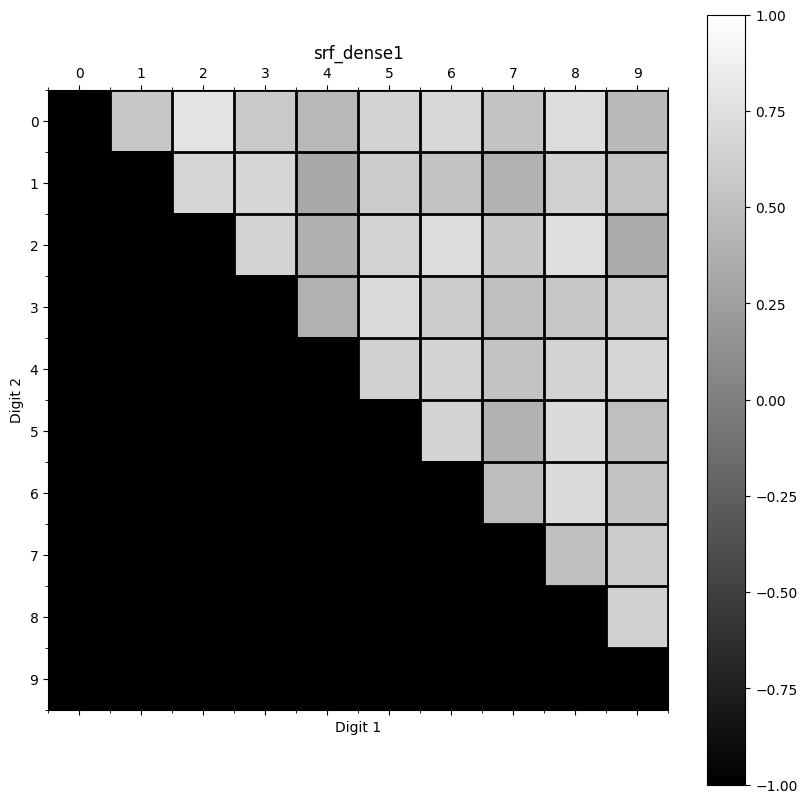

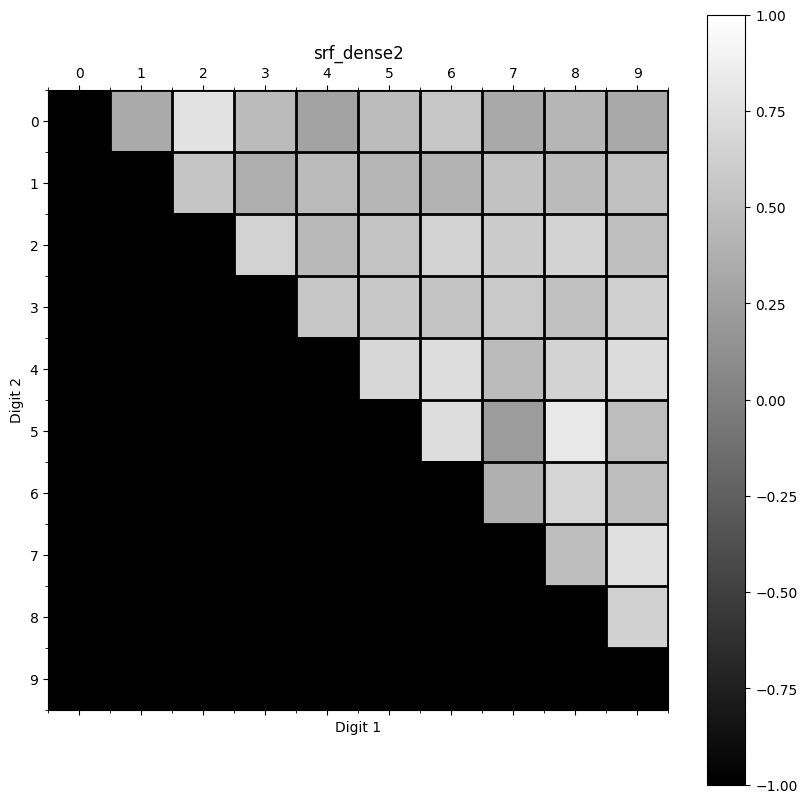

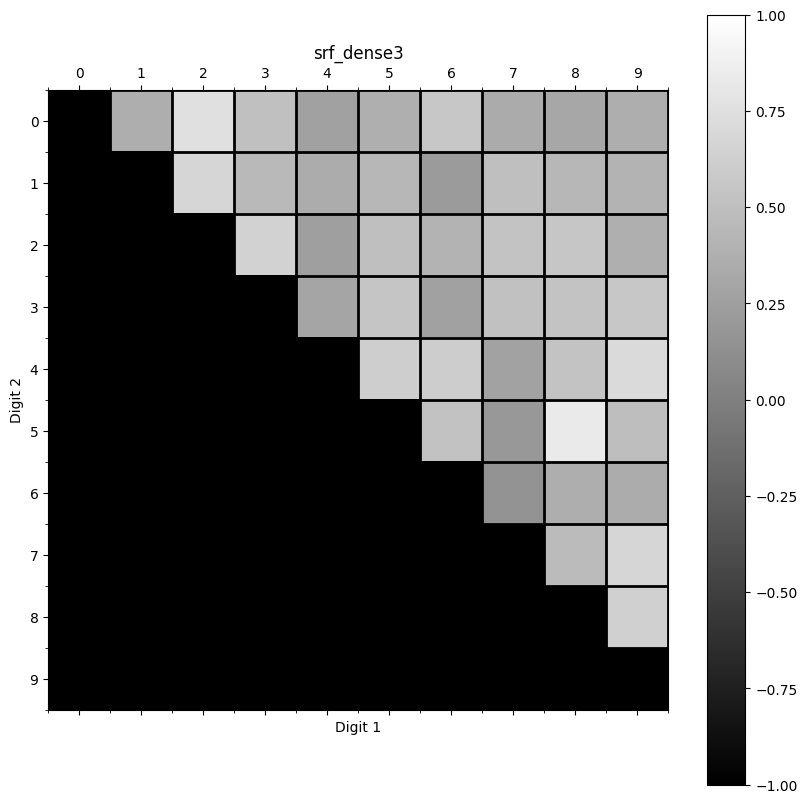

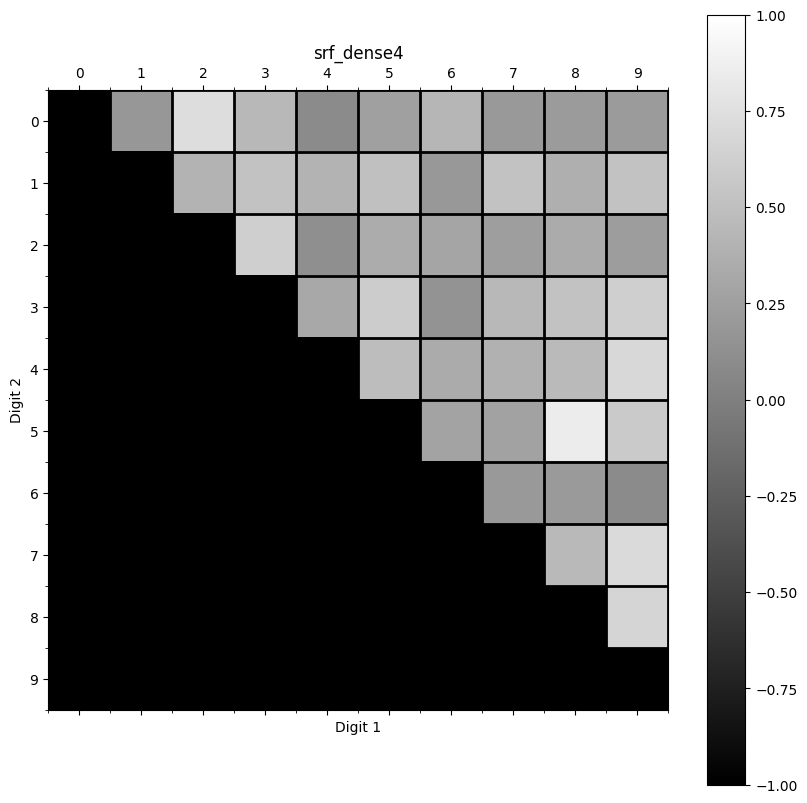

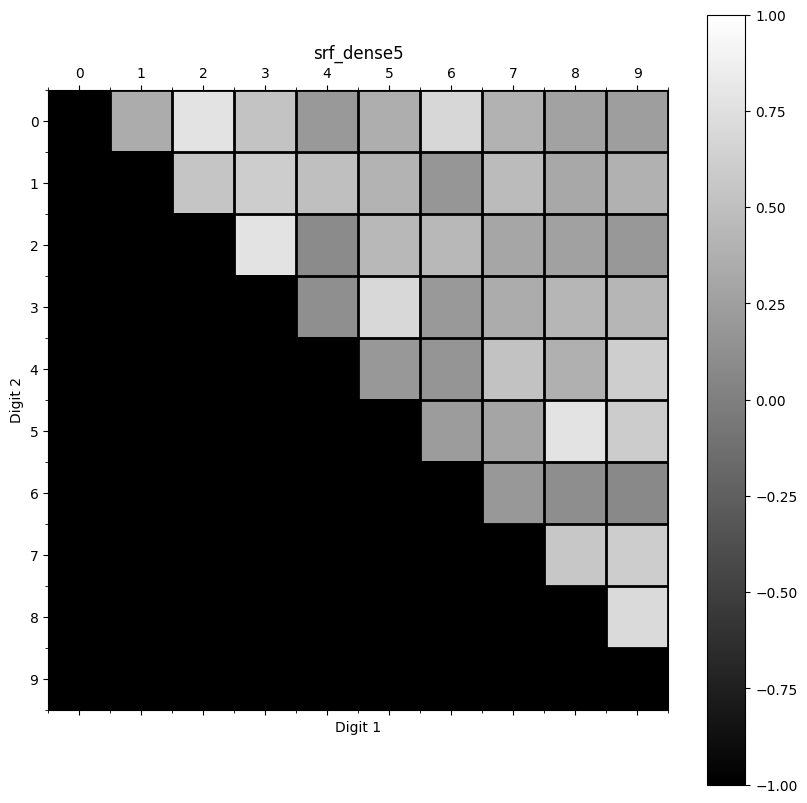

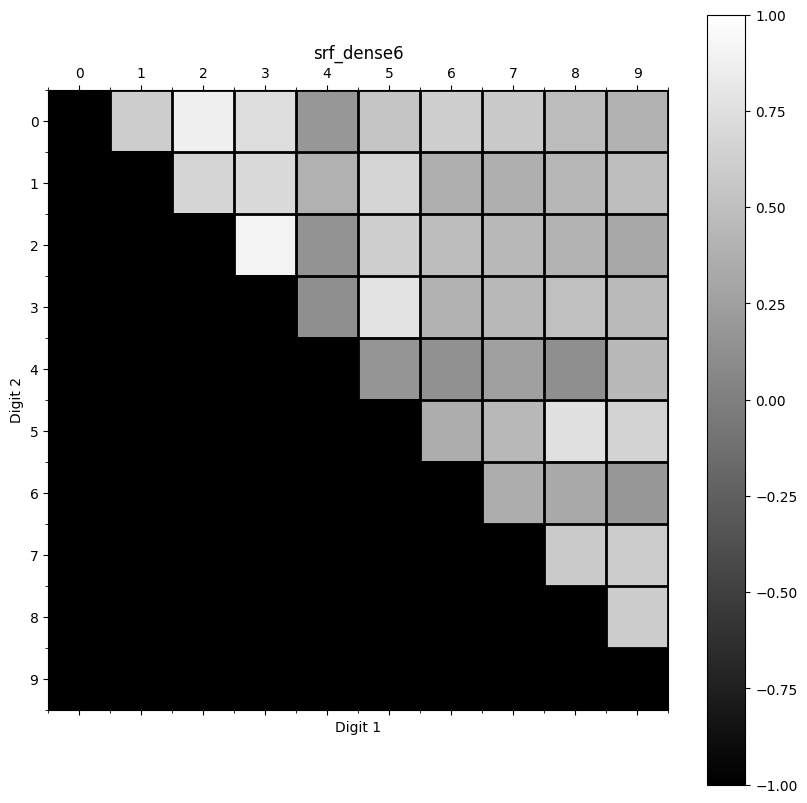

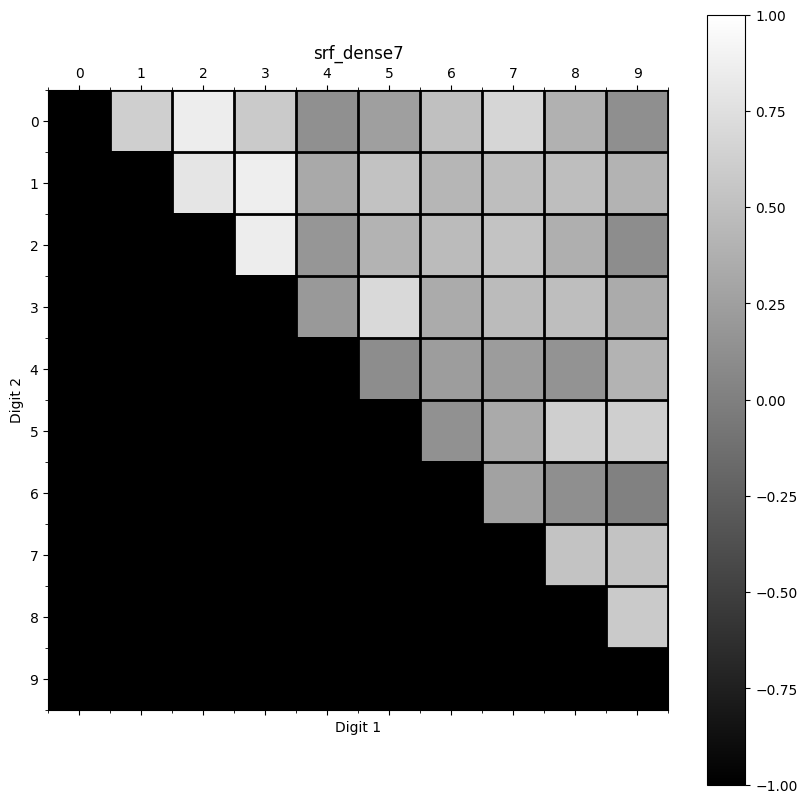

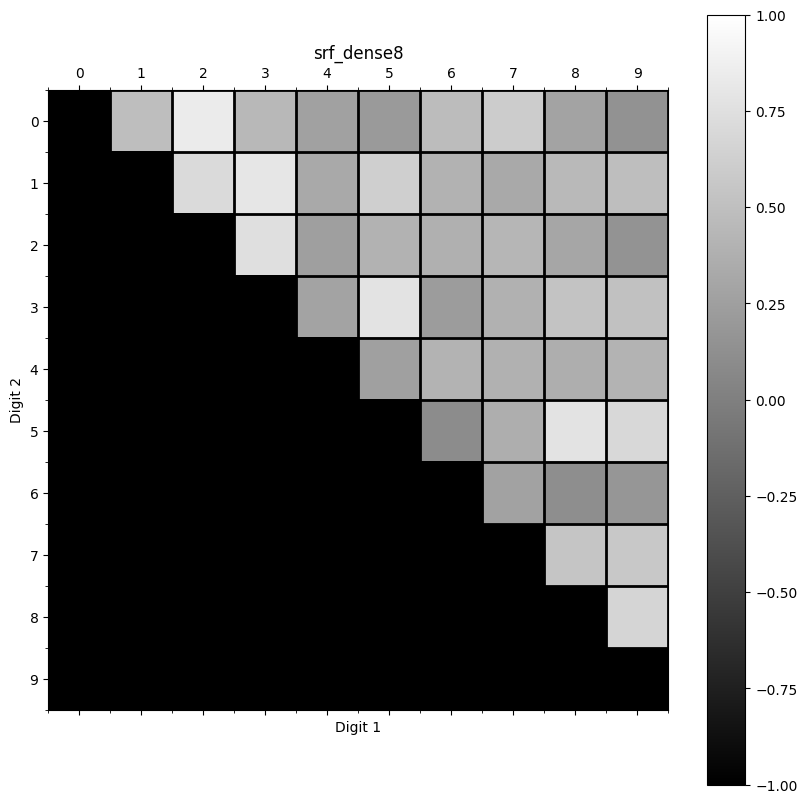

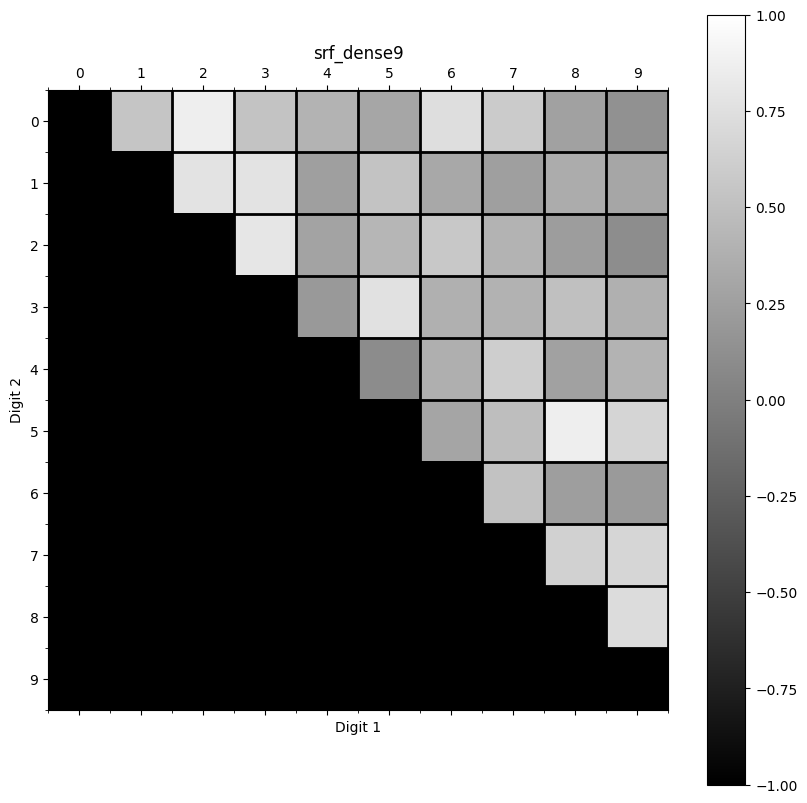

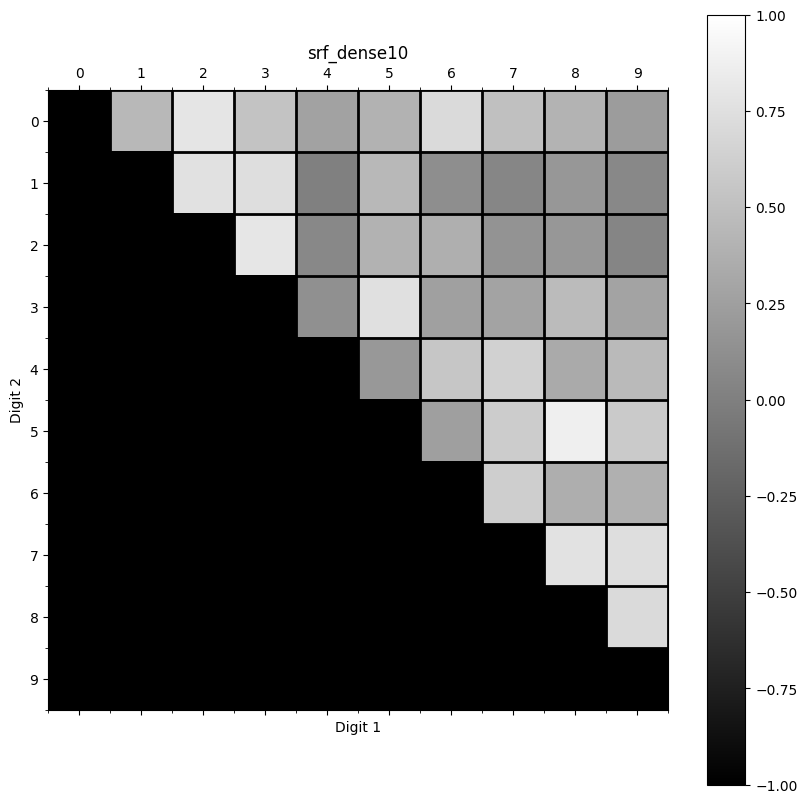

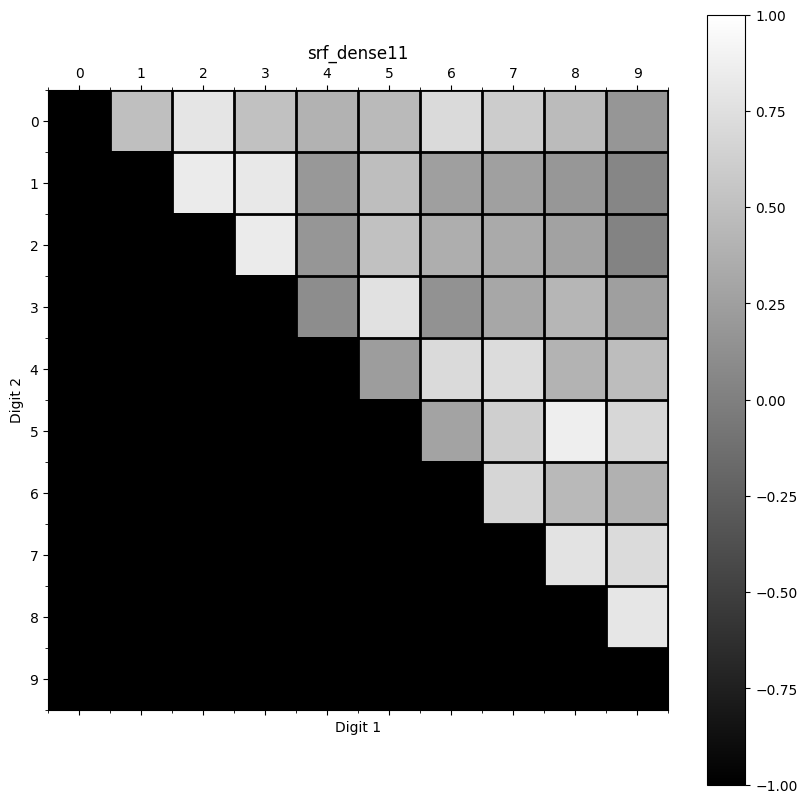

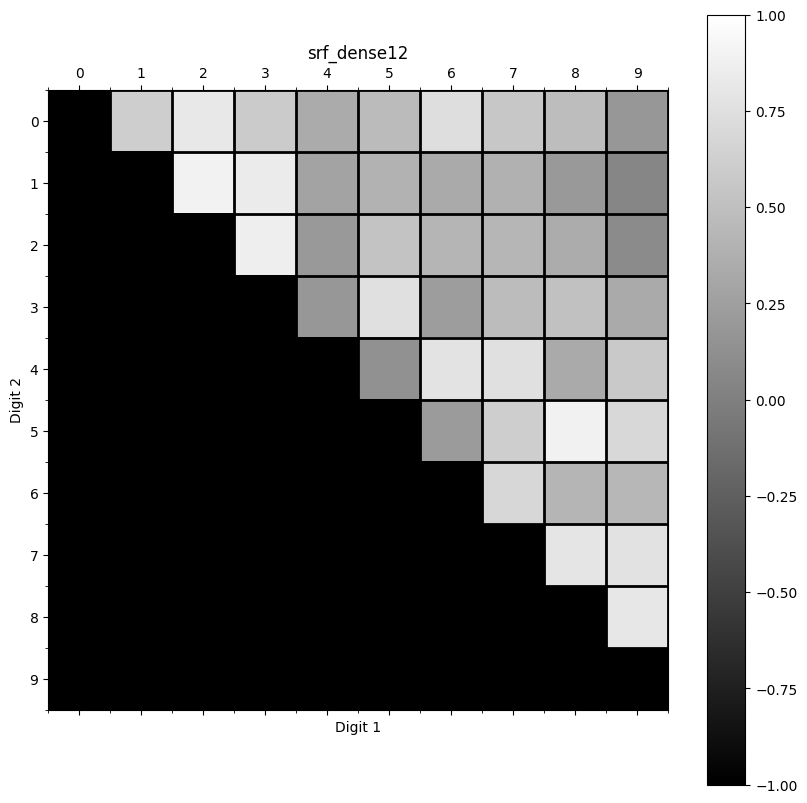

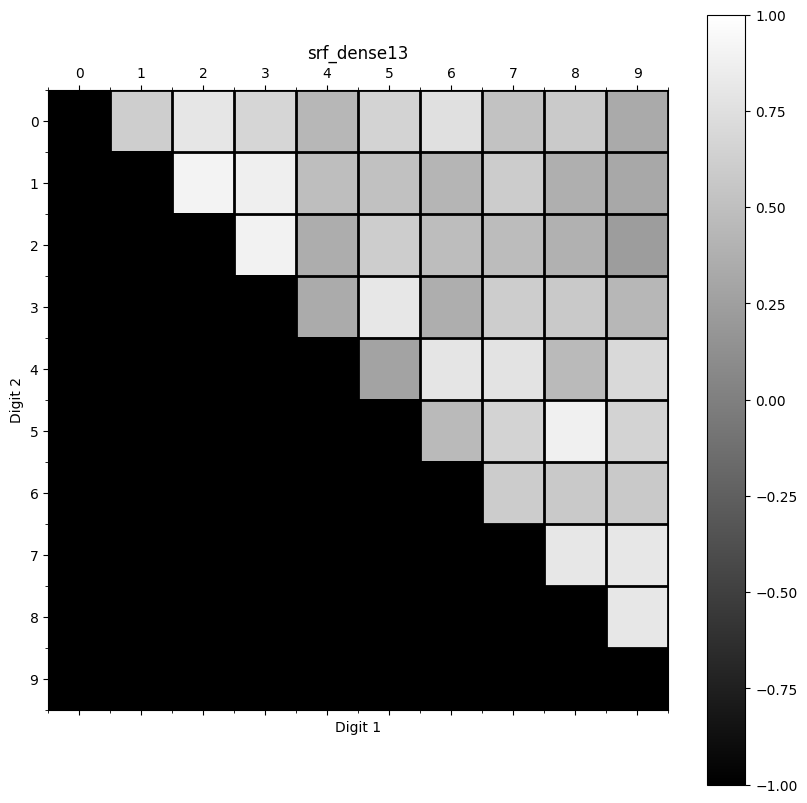

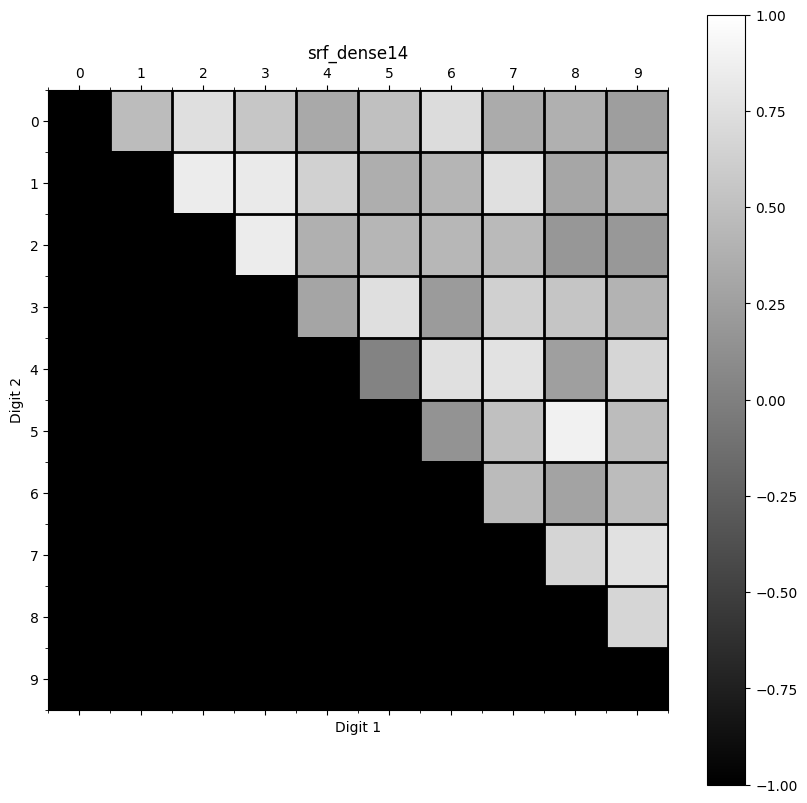

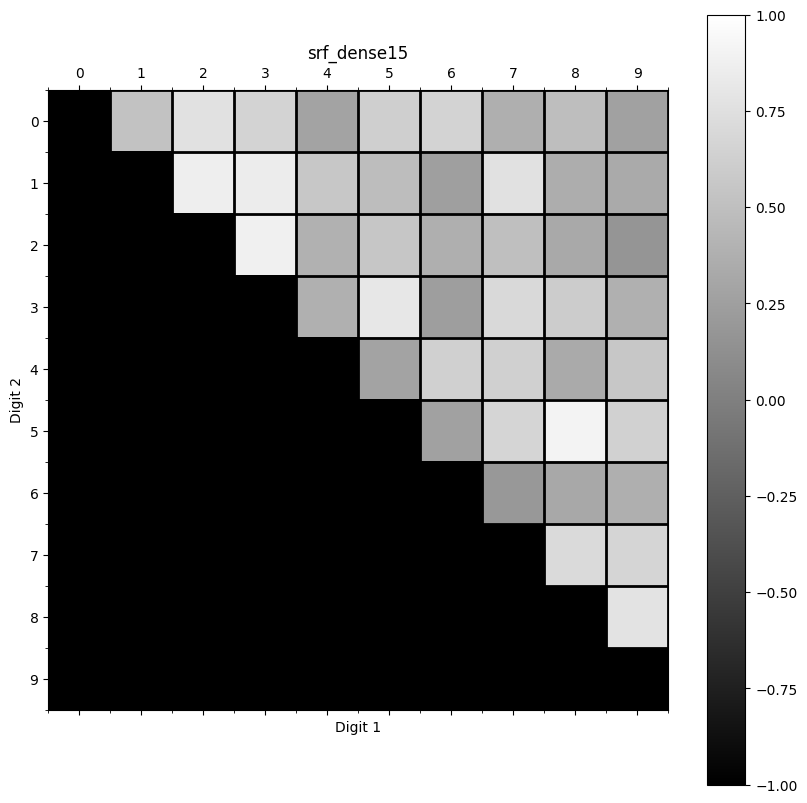

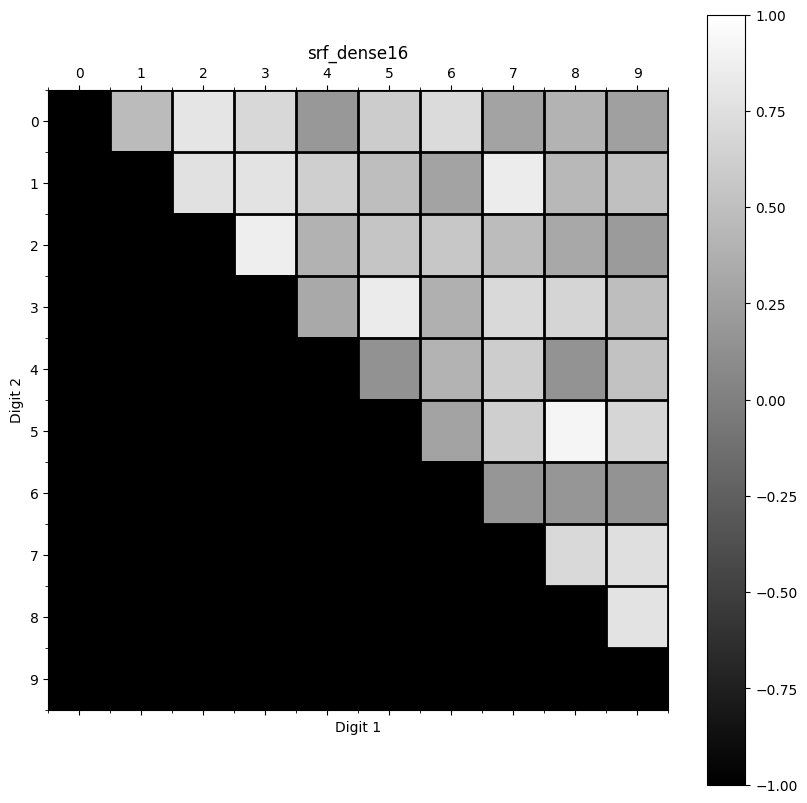

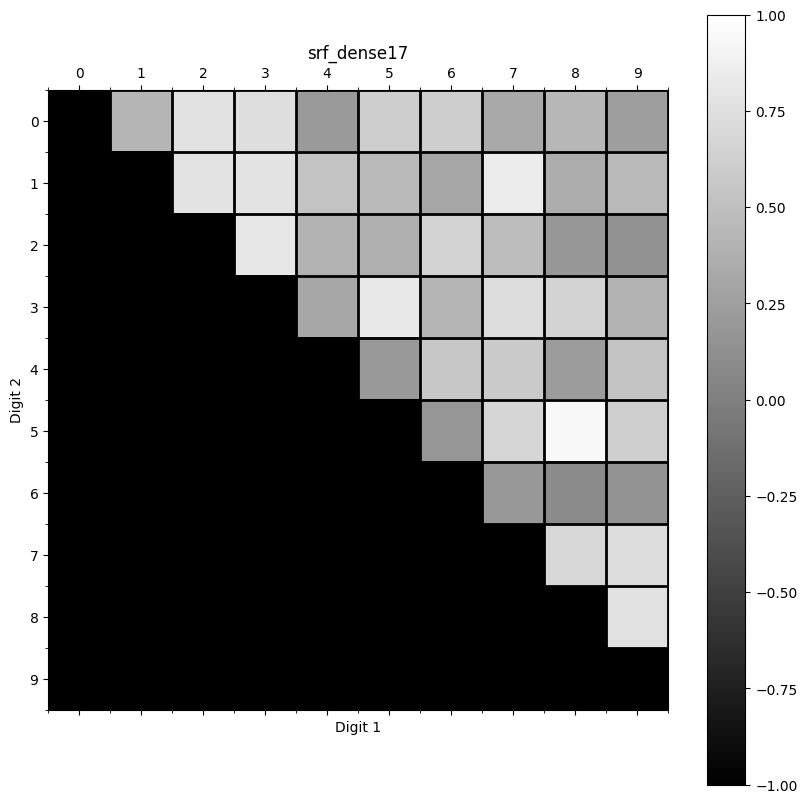

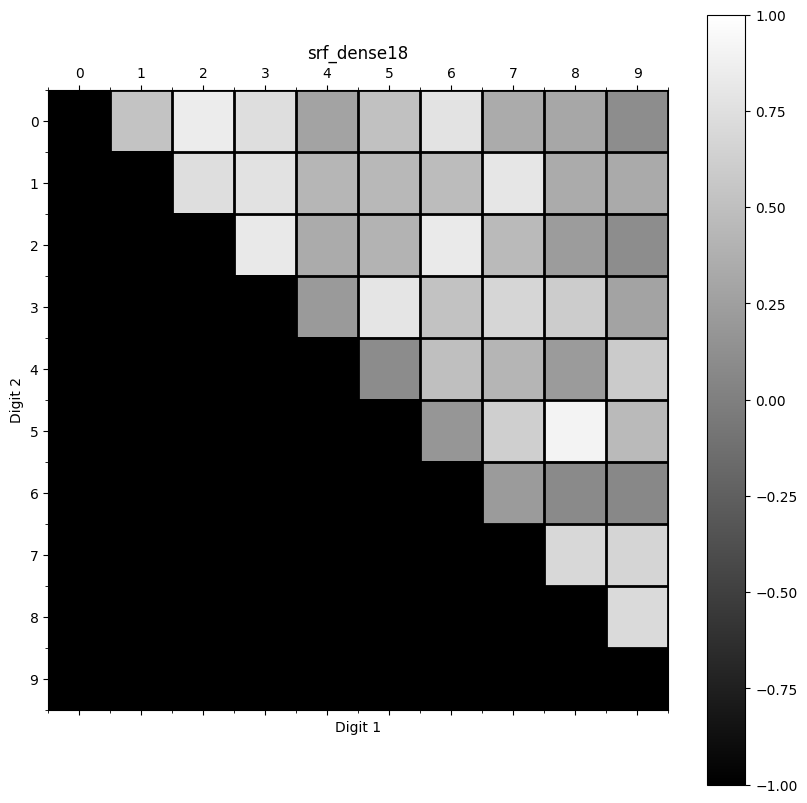

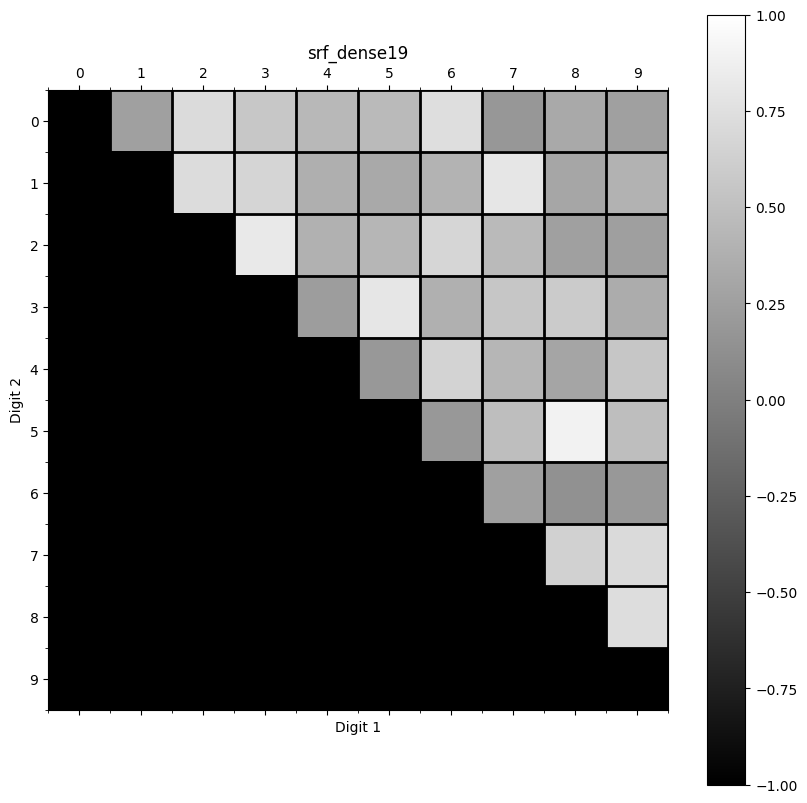

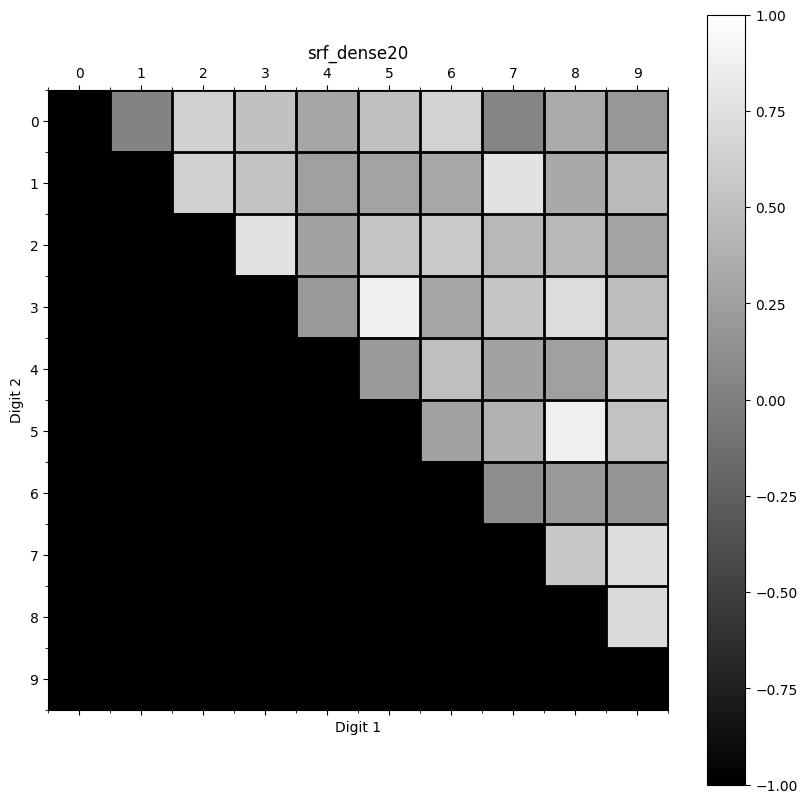

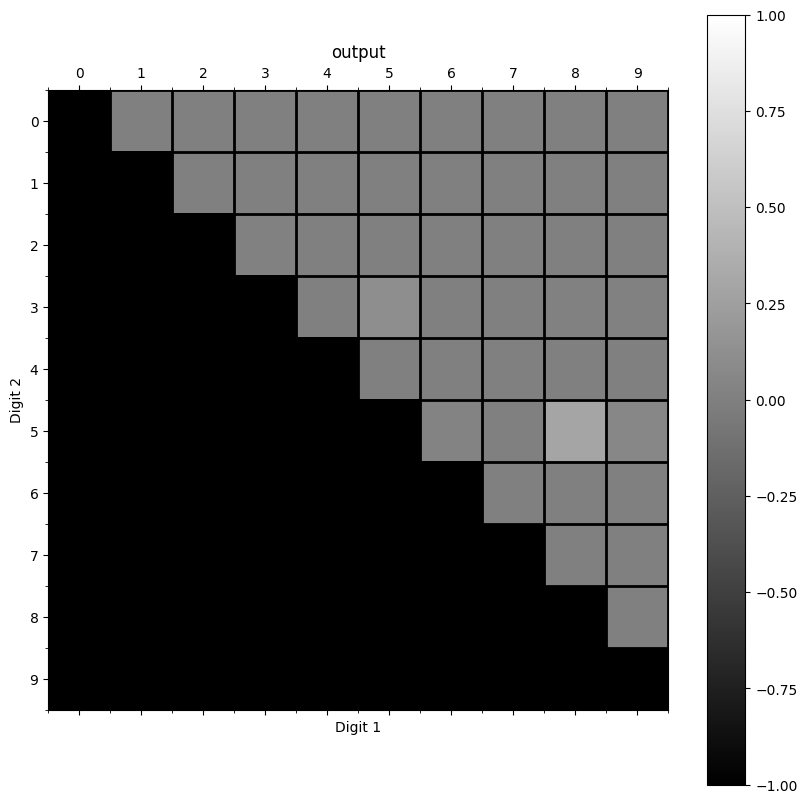

In [120]:
for layer_name in cs_matrices.keys():
    plot_csm(cs_matrices=cs_matrices, layer_name=layer_name, title=layer_name)

### Plot CSM interactively

In [ ]:
plot_csm_interactively(cs_matrices=cs_matrices)

## Compute orthogonality

Auxiliary functions

In [121]:
def compute_avg_off_diagonal(matrix: np.array) -> float:
    """
    Computes the average off-diagonal value of a matrix

    Input:
    matrix: np.array: matrix to compute the average off-diagonal value

    Output:
    float: average off-diagonal value of the matrix
    """

    n = matrix.shape[0]
    off_diagonal_elements = matrix[np.triu_indices(n, k=1)] # np.triu_indices returns indices of upper triangle of matrix (k = 1 to exclude main diagonal)
    avg_off_diagonal = np.mean(off_diagonal_elements)
    
    return avg_off_diagonal

def get_quadrants(matrix: np.array) -> Tuple[np.array, np.array, np.array, np.array]:
    """
    Returns the four quadrants of a matrix

    Input:
    matrix: np.array: matrix to be split into quadrants

    Output:
    Tuple[np.array, np.array, np.array, np.array]: tuple containing the four quadrants of the matrix
    """

    n = matrix.shape[0]
    half_n = n // 2
    upper_left = matrix[:half_n, :half_n]
    upper_right = matrix[:half_n, half_n:]
    lower_left = matrix[half_n:, :half_n]
    lower_right = matrix[half_n:, half_n:]

    return upper_left, upper_right, lower_left, lower_right

### Orthogonality function

In [122]:
def compute_orthogonality(csm: np.array) -> float:
    """
        Computes the orthogonality of a layer

        Input:
        csm: np.array: cosine similarity matrix for a layer

        Output:
        float: orthogonality of the layer
    """
    n = csm.shape[0]
    # If the layer is a DRF layer
    if n == 20:
        upper_left, upper_right, lower_left, lower_right = get_quadrants(csm)
        avg_off_diagonal = (compute_avg_off_diagonal(upper_left) + np.mean(upper_right) + compute_avg_off_diagonal(lower_right)) / 3
    else:
        avg_off_diagonal = compute_avg_off_diagonal(csm)
    
    return 1 - avg_off_diagonal

## Compute orthogonality for layers

### Plotting orthogonality for a group of layers

In [136]:
def compute_orthogonality_grouping_layers(cs_matrices: Dict[str, np.array], group_by_rf: bool = True, is_srf_model: bool = False) -> Dict[str, float]:
    """
    Computes the orthogonality for each group of layers in the model

    Input:
    cs_matrices: Dict[str, np.array]: dictionary containing the cosine similarity matrices for each layer of the model
    group_by_rf: bool: flag to group layers by visual field (left_srf, right_srf, drf or only srf) (default: False)
    is_srf_model: bool: flag to indicate if the model is a single visual field model (default: False)

    Output:
    Dict[str, float]: dictionary containing the orthogonality for each group of layers in the model
    """

    orthogonalities = {}
    for layer_name, csm in cs_matrices.items():                
        if group_by_rf:
            if is_srf_model:
                key = 'srf'
            else:
                key = 'left_srf' if 'left' in layer_name else 'right_srf' if 'right' in layer_name else 'drf'
        else:
            key = re.sub(r'\d+', '', layer_name)
        orth = compute_orthogonality(csm)
        orthogonalities[key] = [orth] if key not in orthogonalities else orthogonalities[key] + [orth]

    return orthogonalities

def compute_mean_and_deviation(values_list: List[Dict[str, np.array]]) -> Tuple[Dict[str, np.array], Dict[str, np.array]]:
    grouped_values = {}
    for values in values_list:
        for key, value in values.items():
            grouped_values[key] = [value] if key not in grouped_values else grouped_values[key] + [value]

    deviations = {}
    mean_values = {}
    for key in grouped_values.keys():
        deviations[key] = np.std(grouped_values[key], axis=0)
        mean_values[key] = np.mean(grouped_values[key], axis=0)
    
    return mean_values, deviations

def plot_orthogonality(orthogonalities: Dict[str, np.array], deviations: Dict[str, np.array] = None, label: str = 'Orthogonality for each group of layers') -> None:
    plt.figure()
    for key, orth in orthogonalities.items():
        drf_keys = {'drf', 'dense'}
        x_values = np.arange(len(orth)) if key not in drf_keys else np.arange(len(orth)-2, 2*len(orth)-2)
        if deviations is not None:
            plt.fill_between(x_values, orth - deviations[key], orth + deviations[key], alpha=0.2)
        plt.plot(x_values, orth, label=key)
            
    plt.title(label)
    plt.xlabel('Layer instance')
    plt.ylabel('Orthogonality')
    #plt.xticks(np.arange(20))
    plt.legend()
    plt.show()

In [127]:
csm_list = []
prototypes_list = []
for model in models:
    prototypes = generate_prototypes_mp(model=model, x_data=x_test, y_data=y_test, n=2)
    cs_matrices = compute_cosine_similarity_matrix(model=model, prototypes=prototypes)
    prototypes_list.append(prototypes)
    csm_list.append(cs_matrices)

[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess prototype calculation!
[Cosine similarity] Starting multiprocess prototype calculation...
[Cosine similarity] Done multiprocess

In [31]:
csm_list = []
for i in range(10):
    cs_matrices = load_obj(f'cosine_similarity/model_t1_denser_{i}.csm')
    csm_list.append(cs_matrices)

In [ ]:
save_obj('cosine_similarity/model_t1_srf_list.csm', csm_list)

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


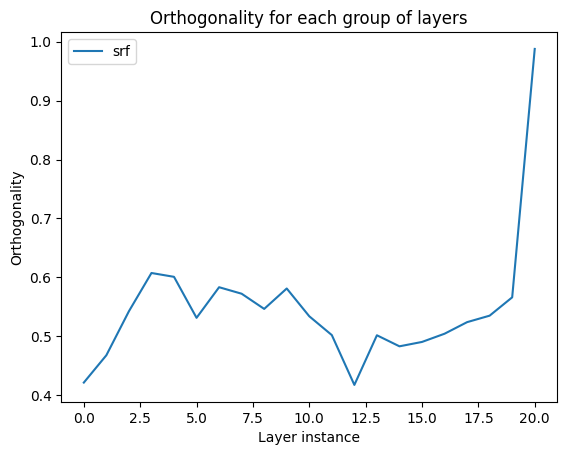

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


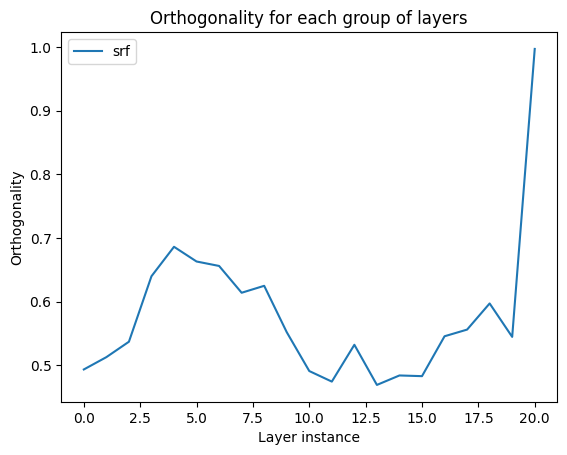

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


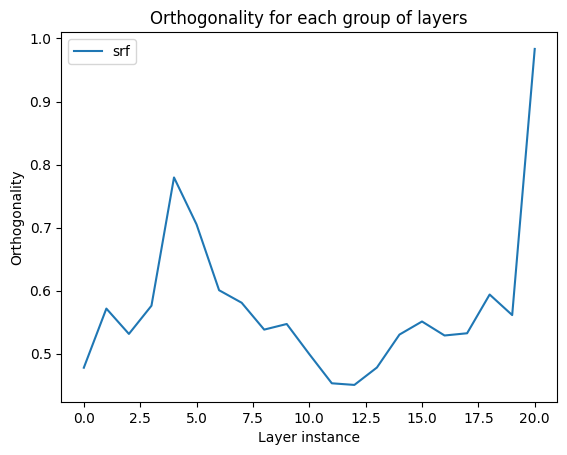

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


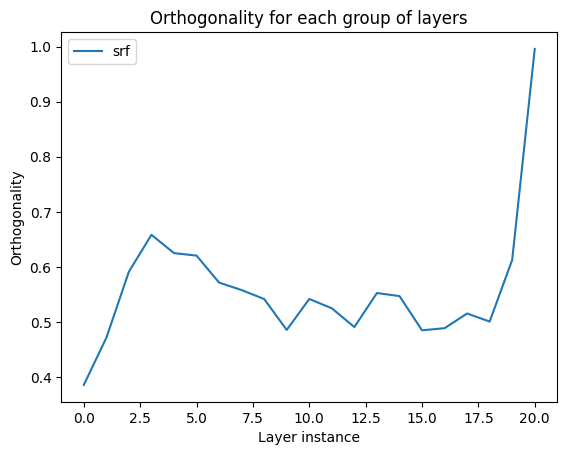

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


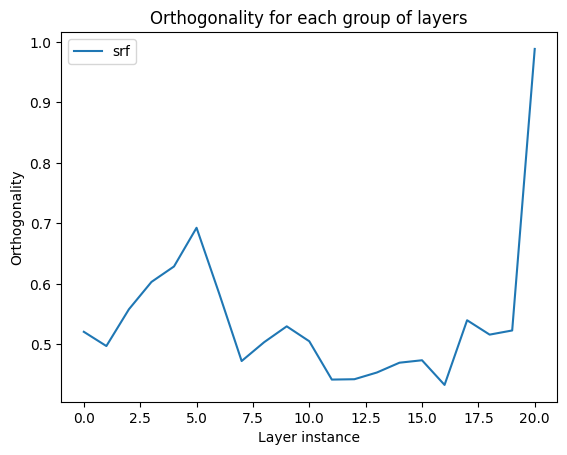

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


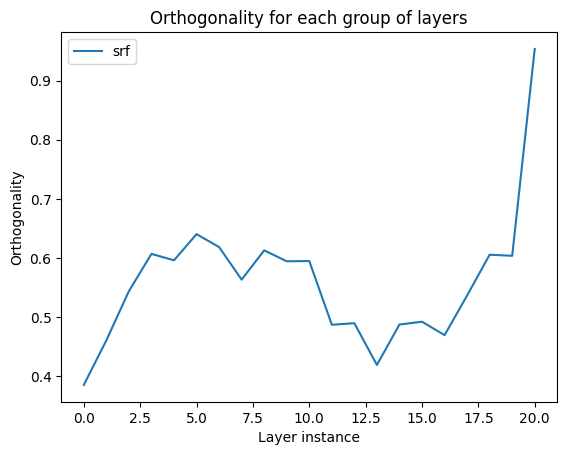

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


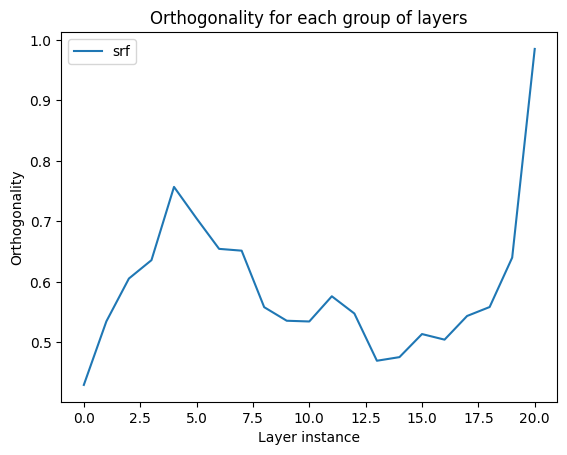

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


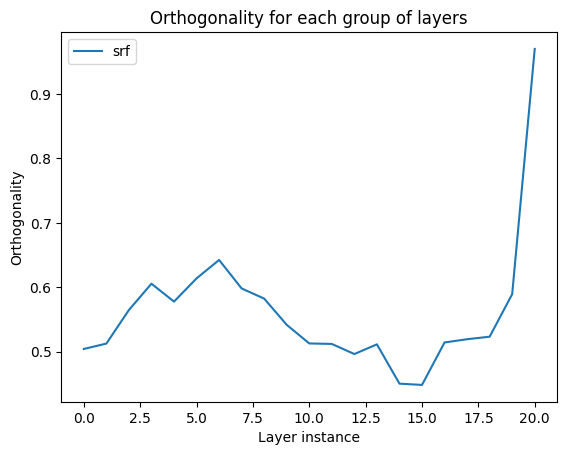

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


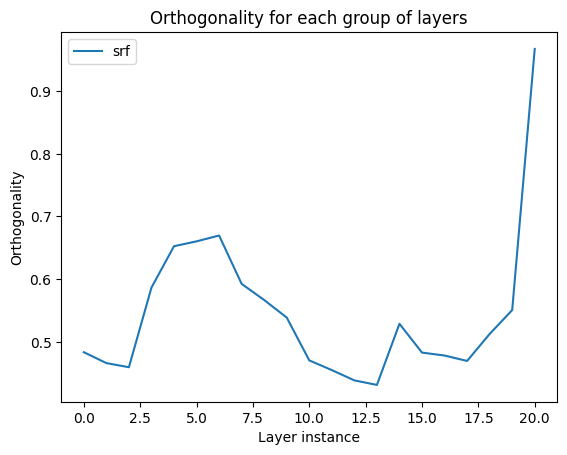

srf
21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


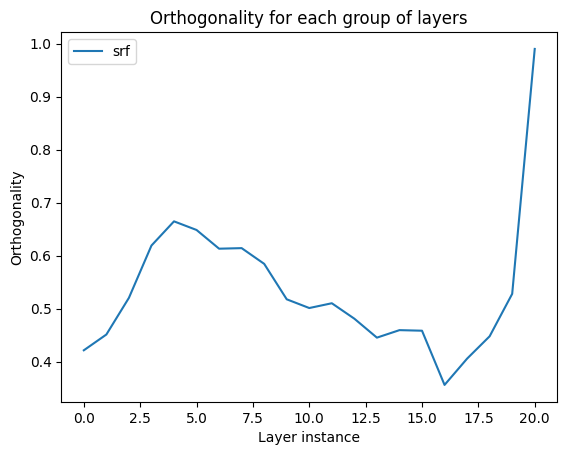

In [135]:
values_list = []
for d_csm in csm_list:
    values = compute_orthogonality_grouping_layers(d_csm, is_srf_model=True)
    plot_orthogonality(values)
    values_list.append(values)

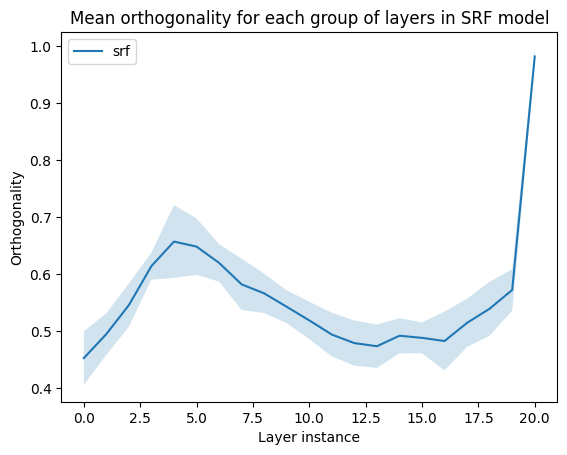

In [138]:
mean, deviations = compute_mean_and_deviation(values_list)
plot_orthogonality(mean, deviations=deviations, label='Mean orthogonality for each group of layers in SRF model')

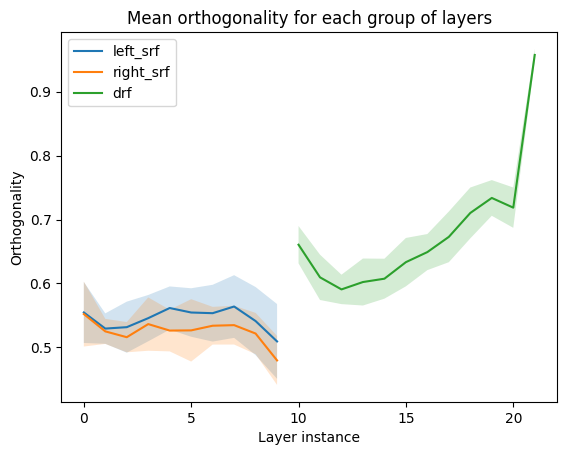

In [56]:
mean, deviations = compute_mean_and_deviation(values_list)
plot_orthogonality(mean, deviations=deviations, label='Mean orthogonality for each group of layers')

### Próximos passos

plot sequencial das camadas com desvio padrão  
    1) seperar em left srf, right srf e drf (inclui concat e output)  
    2) recebe valor y e plota  
    3) pode ser q y seja media e pode receber também std deviation (adicional)    
        3.1) se sim, plota os dois, std deviation será sombra  
FEITO!

ortogonalidade para modelo totalmente SRF  
    1) mudar args gen para 1 só yield  
    2) mudar compute activations para 1 vf  
    3) mudar csm calc para 1 vf  
   
calcular csm para cada modelo treinado
calcular ortogonalidade, media e desvio delas
plotar
